# Описание бизнес-задачи

Представим, что мы аналитик в крупной сети ритейл-магазинов. И нас просят построить систему прогнозирования продаж товаров на 1 неделю вперед, чтобы понимать, сколько товаров завозить в магазин на следующей неделе. Также нас просят оценить точность нашего прогноза, чтобы понимать, насколько хорош наш алгоритм и насколько можно ему доверять.

Руководство компании предоставило нам данные о продаже разных категорий товаров в крупном магазине по дням и по часам. В этих данных есть следующие колонки:

- `category_id` - id категории
- `date` - дата
- `hour` - час, за который отсчитывается число продаж
- `num_sells_in_hour` - число продаж этого товара за один час

Как мы понимаем, перед нами данные из реальной жизни. Поэтому какие-то товары могут быть очень новыми и у них слишком короткая история для прогнозирования продаж для них. Некоторые товары дорогие и покупаются не каждый час. В общем все, что присуще продажам товаров в магазинах.

Все происходящее в нашем отчете будет по возможности проиллюстрировано графиками, так как директору отдела закупок легче воспринимать информацию в графическом виде.

Это было описание бизнес-кейса. Давайте теперь сформулируем техническое задание к данному бизнес-кейсу.

## Задача прогнозирования продаж в сети ритейл-магазинов

### Вопрос: 
Какую задачу решает мой проект?
### Ответ:
Прогнозирование продаж товаров на неделю вперед для планирования завоза товаров в магазины&

### Вопрос: 
Какие зависимости я хочу исследовать, на какие вопросы по данным я хочу ответить? 
### Ответ:
- Есть ли в данных внутридневная/внутринедельная сезонность?
- Какой алгоритм лучше всего (по метрикам качества) сможет строить прогноз?
- С какой точностью можно спрогнозировать продажи товаров по трехмесячной истории продаж категории?

### Вопрос: 
Откуда я возьму для него данные? 
### Ответ:
Предоставило руководство магазина (на самом деле эти данные взяты из kaggle-соревнования).

### Вопрос: 
Какие подходы я хочу попробовать и почему?
### Ответ:
Линейная регрессия и Prophet, потому что линейная регрессия - это простой метод регрессии, а Prophet хорошо подходит для временнЫх рядов.

### Вопрос: 
Какова целевая функция, как оценить результат?
### Ответ: 
Mean Squared Error (MSE), Mean Absolute Error (MAPE).

# Подробнее про оценку качества алгоритма прогнозирования:
- разобьем данные на **train** и **test**.
- обучимся на **train**, применим алгоритм к **test**.
- посчитаем метрики MSE и MAPE.

P.S. Верхнеуровневый план работы:
- сагрегировать данные по часам в дни.
- обучить алгоритм прогнозирования.
- посчитать метрики качества.

## 1. Исследовательский анализ данных

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from tqdm import tqdm_notebook

In [ ]:
FILENAME = "kaggle_retail_competition.csv"
df = pd.read_csv(FILENAME)
df.head()

category_id        date  hour  num_sells_in_hour
0         8940  2018-05-25     8                 16
1         8940  2018-05-25     9                 22
2         8940  2018-05-25    10                 15
3         8940  2018-05-25    11                 24
4         8940  2018-05-25    12                 22

In [ ]:
sorted(df['date'].unique())

['2018-05-03',
 '2018-05-04',
 '2018-05-05',
 '2018-05-06',
 '2018-05-07',
 '2018-05-08',
 '2018-05-09',
 '2018-05-10',
 '2018-05-11',
 '2018-05-12',
 '2018-05-13',
 '2018-05-14',
 '2018-05-15',
 '2018-05-16',
 '2018-05-17',
 '2018-05-18',
 '2018-05-19',
 '2018-05-20',
 '2018-05-21',
 '2018-05-22',
 '2018-05-23',
 '2018-05-24',
 '2018-05-25',
 '2018-05-26',
 '2018-05-27',
 '2018-05-28',
 '2018-05-29',
 '2018-05-30',
 '2018-05-31',
 '2018-06-01',
 '2018-06-02',
 '2018-06-03',
 '2018-06-04',
 '2018-06-05',
 '2018-06-06',
 '2018-06-07',
 '2018-06-08']

Даны данные за 37 дней.

In [ ]:
df['date'].nunique()

37

Даны данные для 181 товара.

In [ ]:
df['category_id'].nunique()

181

Видим, что не по всем товарам есть полная история в 37 дней.

In [ ]:
def plot_categories_distribution(df: pd.DataFrame):
    """
    Визуализирует распределение категорий товаров.

    :param df: категории
    """
    plt.figure(figsize=(25, 8))

    sns.barplot(x=df.index, y=df.values, 
                alpha=1, edgecolor="k", linewidth=1, palette="Spectral_r")
    plt.xticks(rotation=90)
    plt.title('Распределение историй продаж по всем товарам', fontsize = 22)
    plt.xlabel('Категории товаров', fontsize=16)
    plt.ylabel('Число дней в истории продаж', fontsize=16)
    
    plt.show()

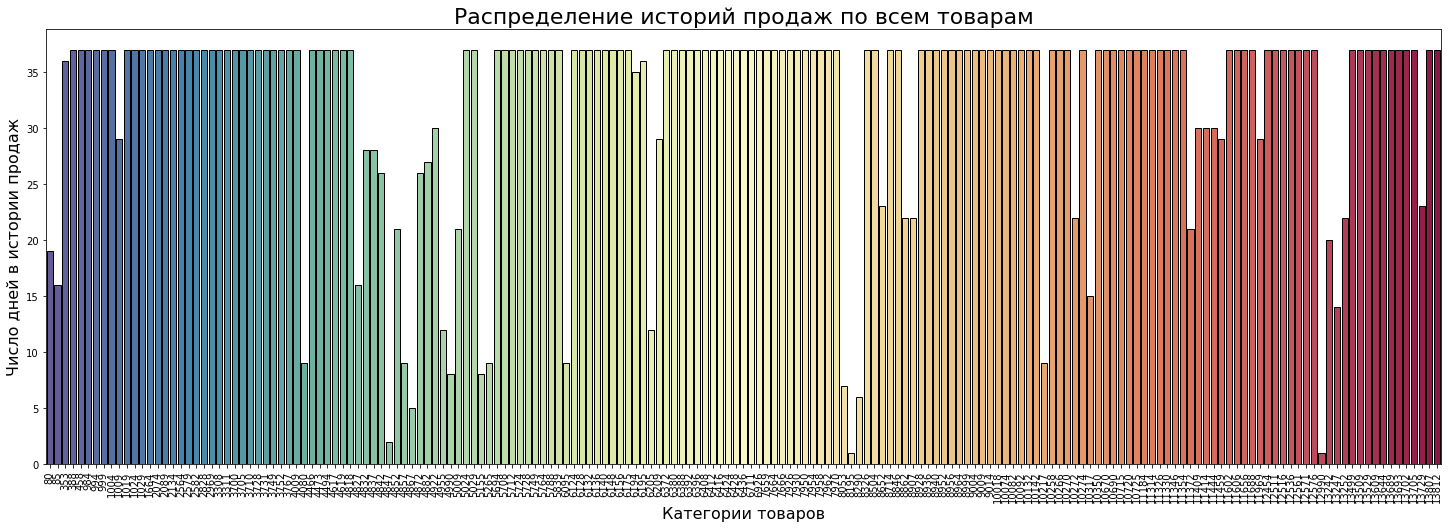

category_id
8195      1
12990     1
4847      2
4867      5
8290      6
         ..
6156     37
6175     37
6372     37
6128     37
13812    37
Name: date, Length: 181, dtype: int64

In [ ]:
plot_categories_distribution(df.groupby('category_id')['date'].nunique().sort_values())
df.groupby('category_id')['date'].nunique().sort_values()

In [ ]:
MAX_HISTORY_LEN = 37
(df.groupby('category_id')['date'].nunique().sort_values() == MAX_HISTORY_LEN).sum()

135

Сохраним товары с полной историей в отдельный список (он пригодится дальше).

In [ ]:
categories_history_lengths = df.groupby('category_id')['date'].nunique().sort_values() >= MAX_HISTORY_LEN
full_history_categories = categories_history_lengths.index[categories_history_lengths].tolist()
len(full_history_categories)


135

Только для 135 товаров есть полная история. Для сравнения метрик качества алгоритмов будем использовать только эти 135 товаров с полной историей

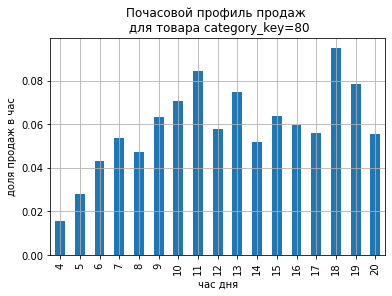

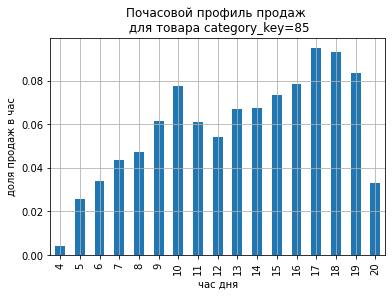

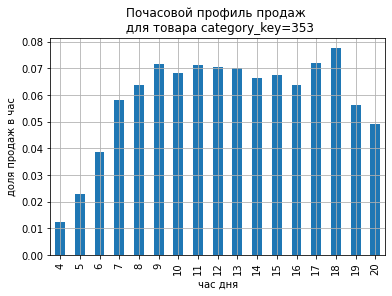

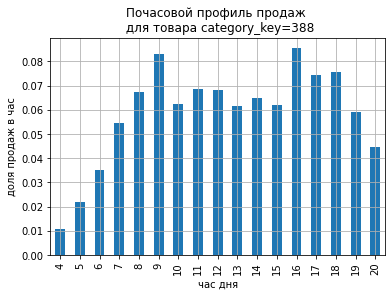

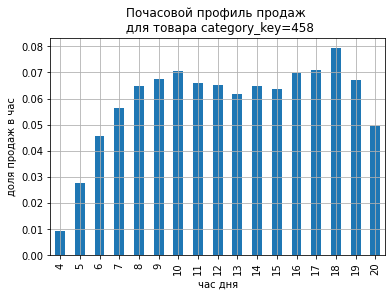

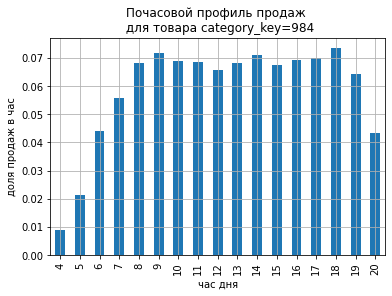

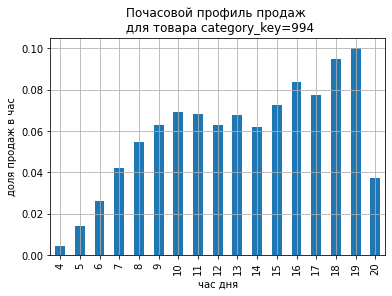

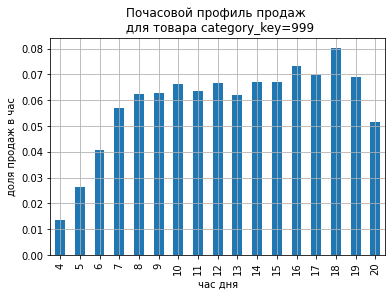

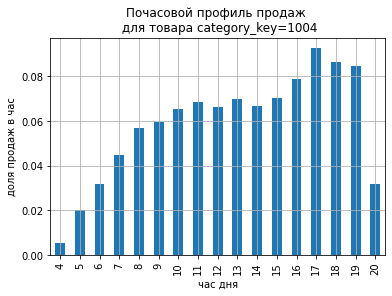

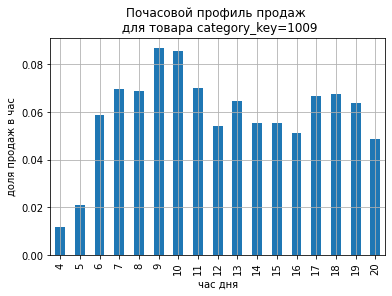

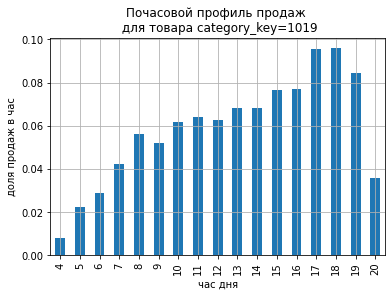

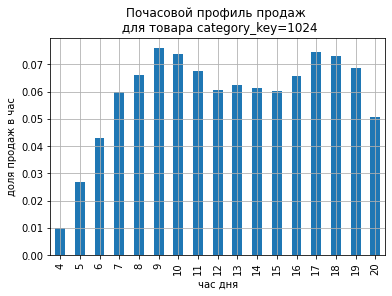

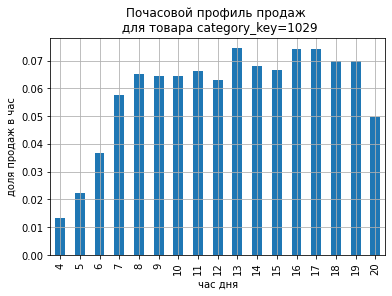

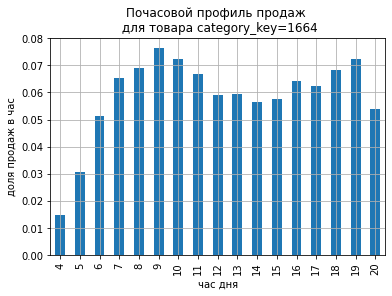

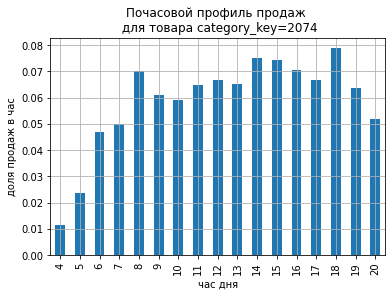

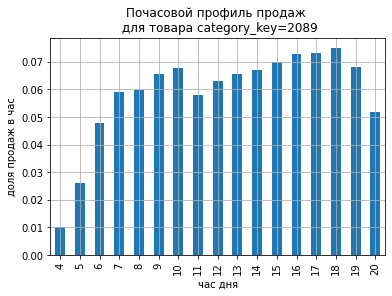

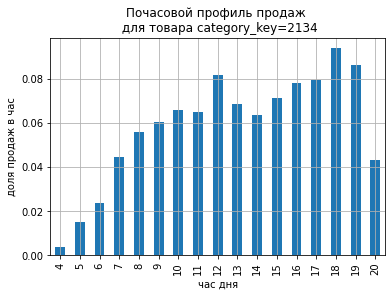

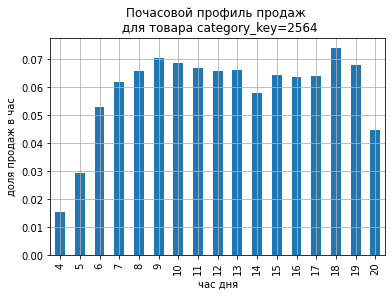

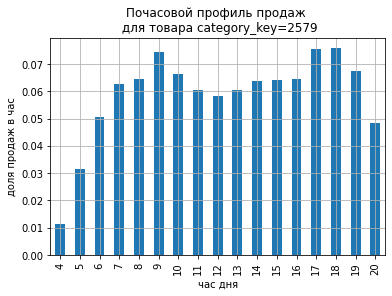

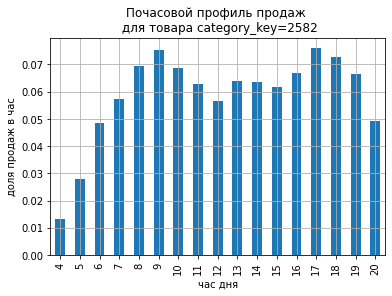

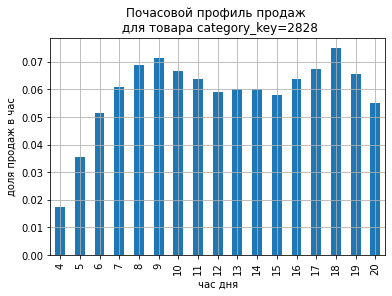

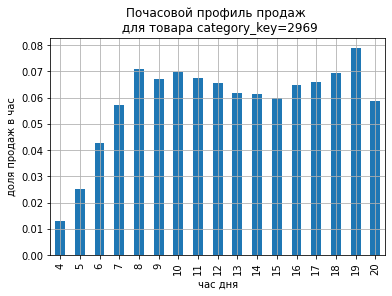

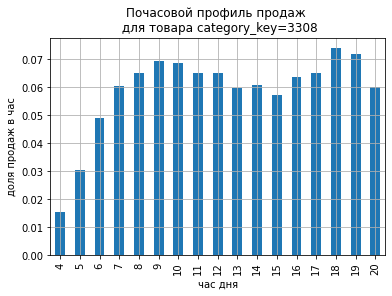

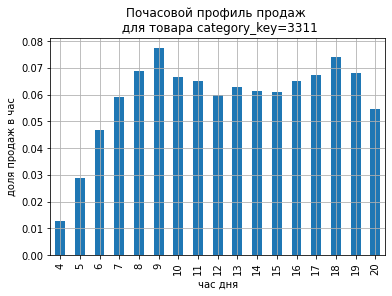

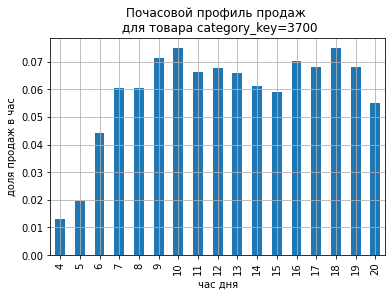

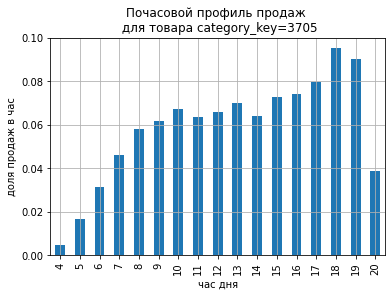

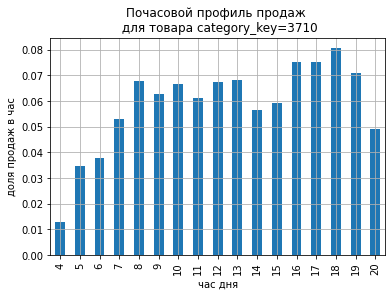

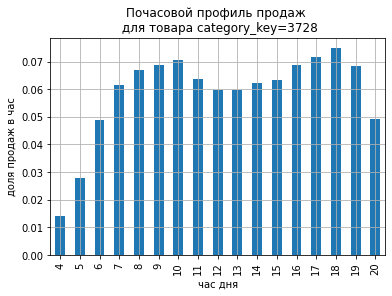

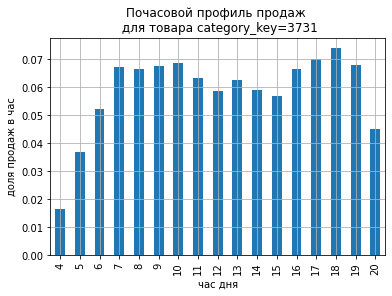

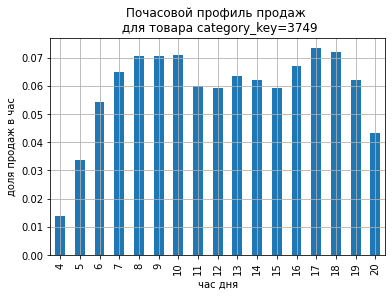

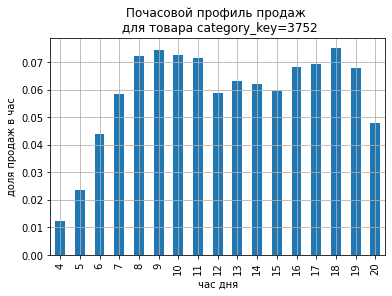

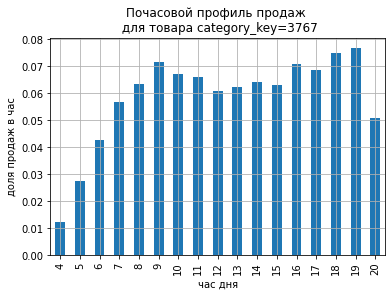

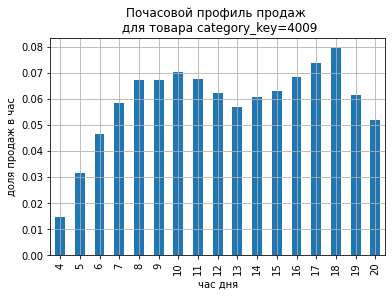

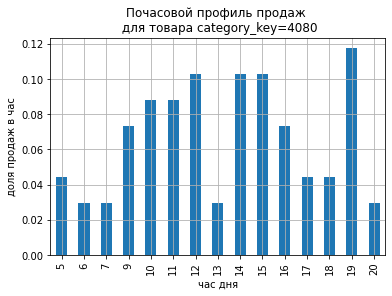

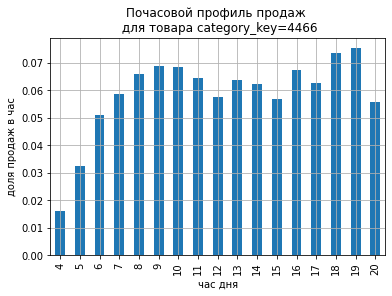

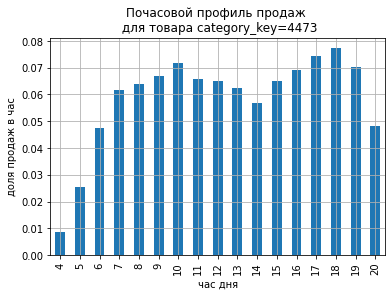

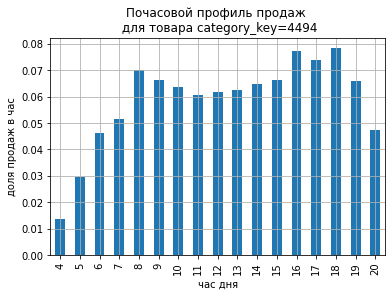

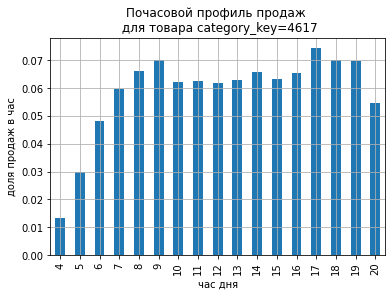

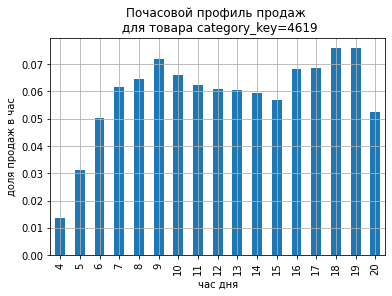

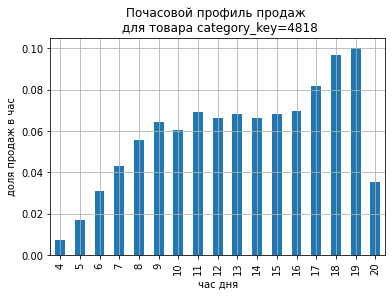

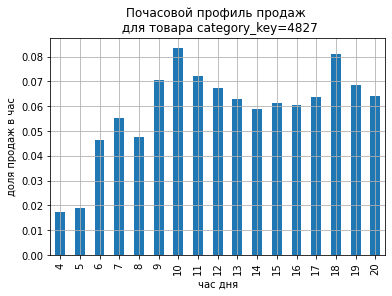

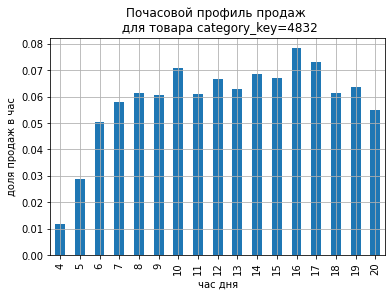

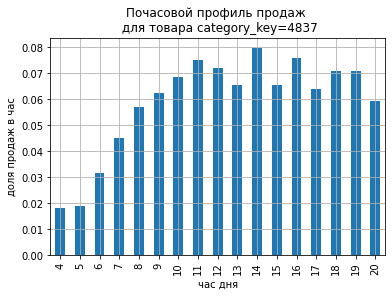

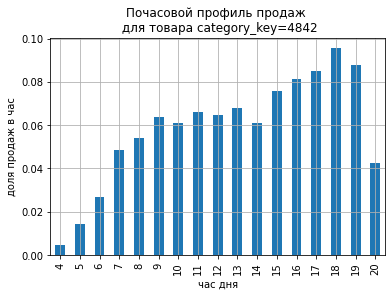

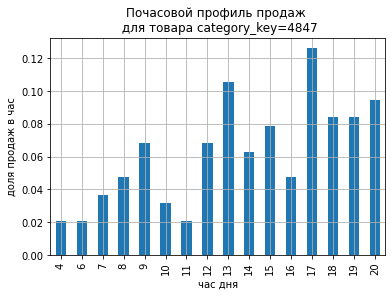

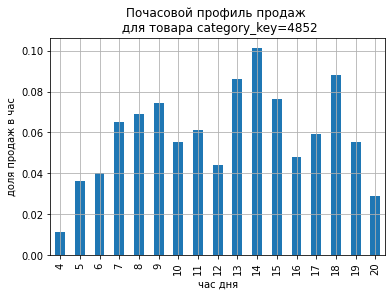

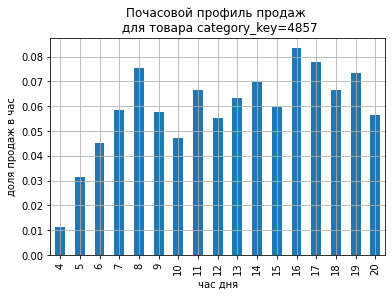

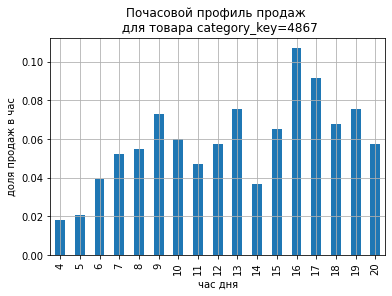

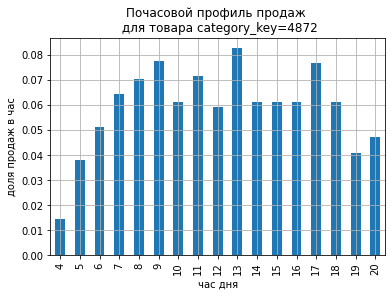

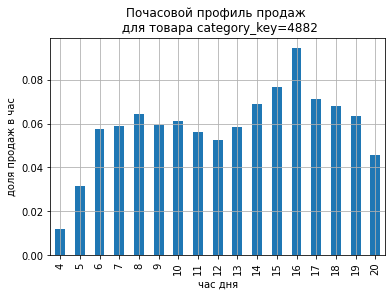

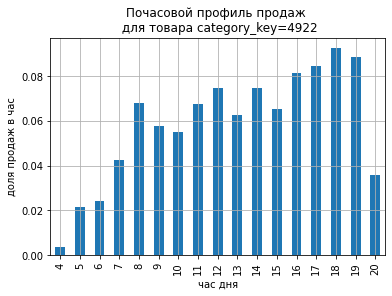

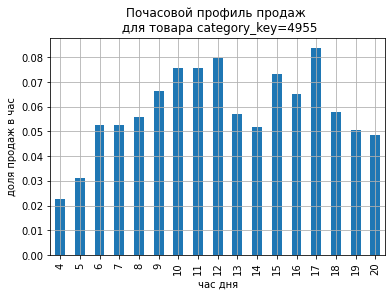

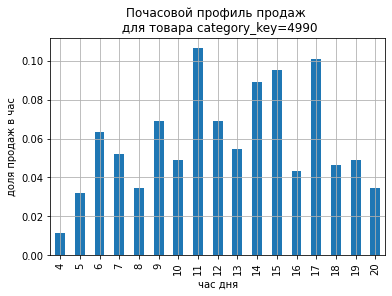

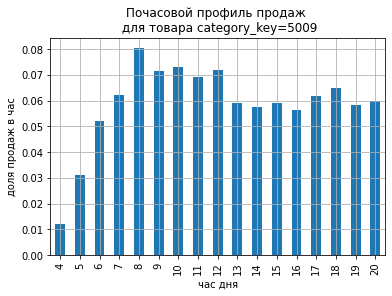

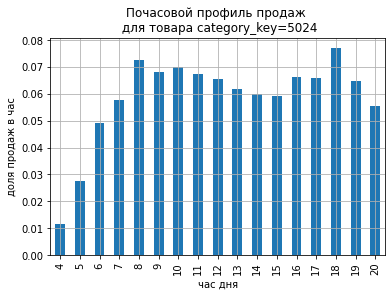

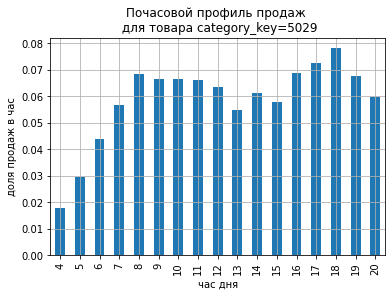

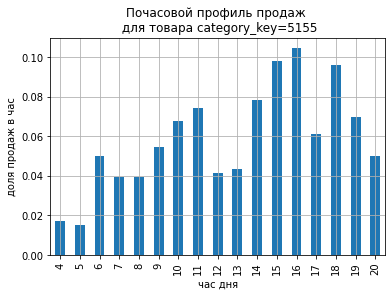

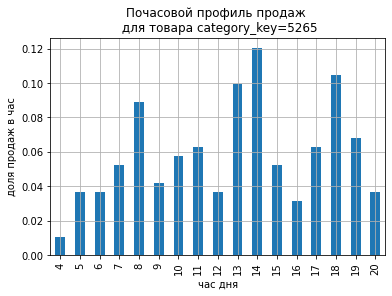

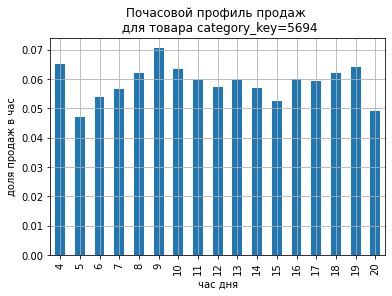

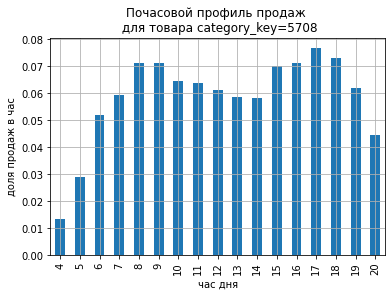

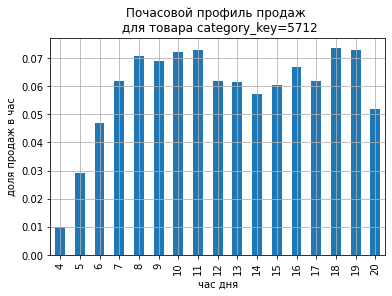

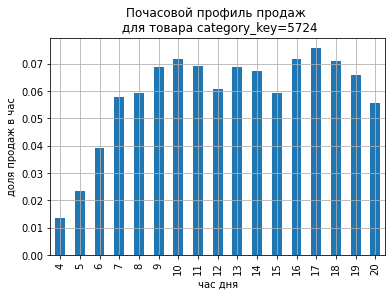

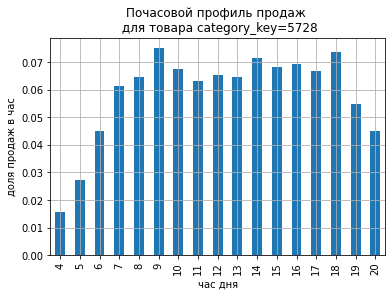

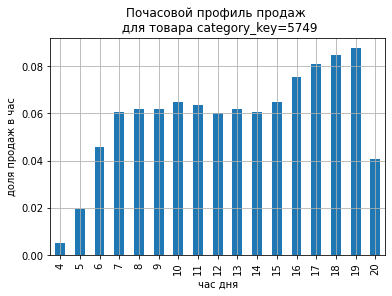

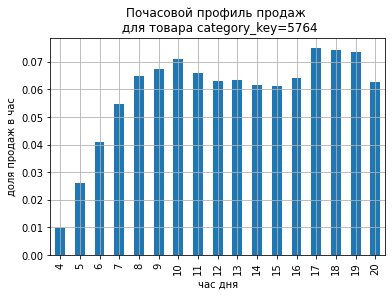

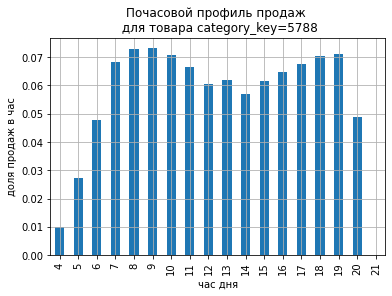

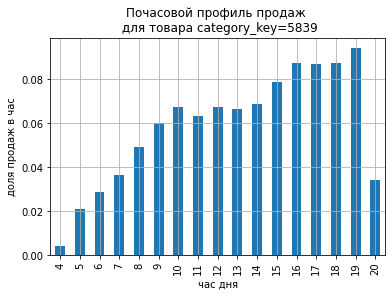

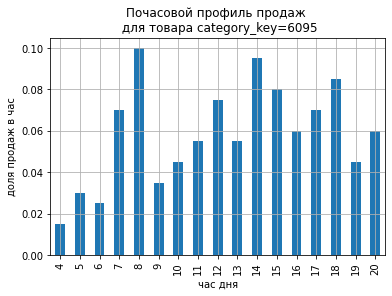

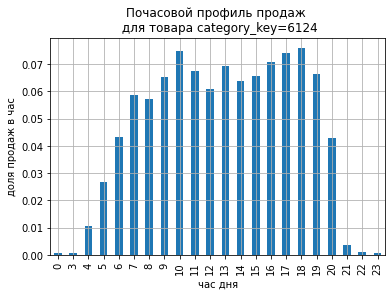

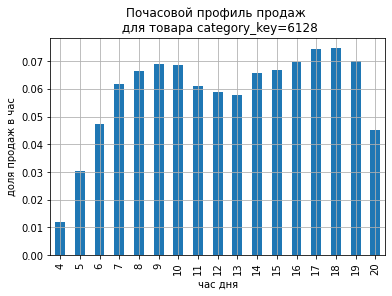

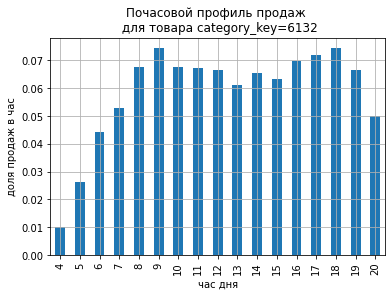

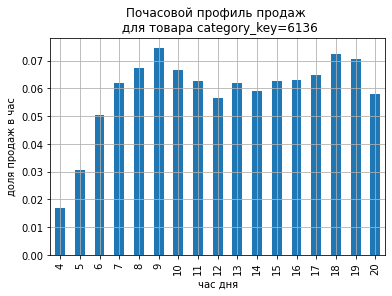

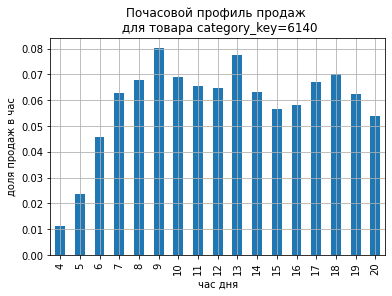

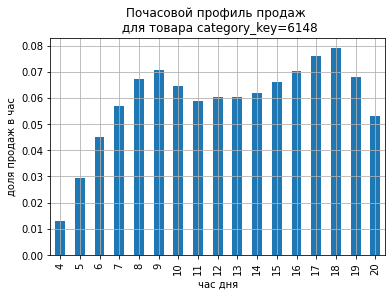

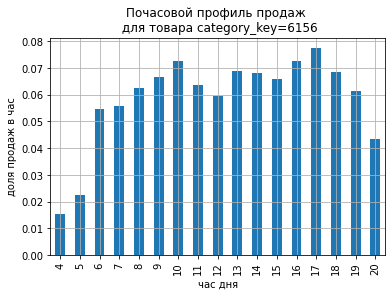

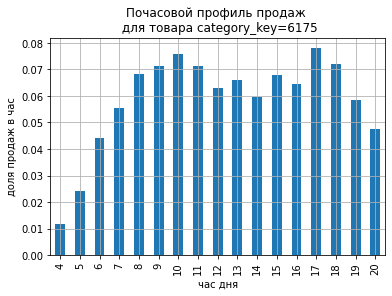

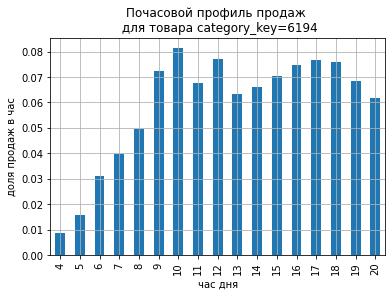

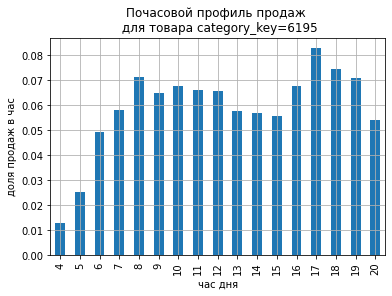

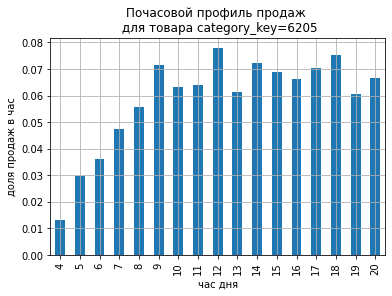

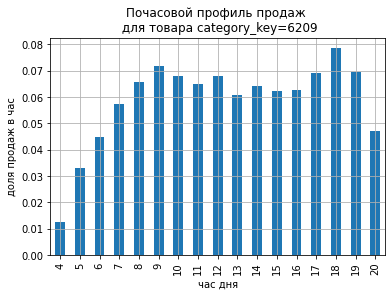

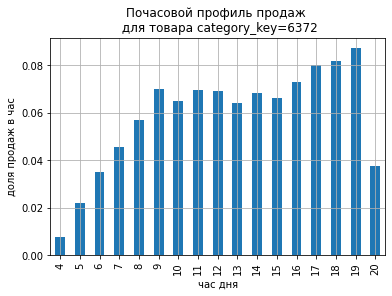

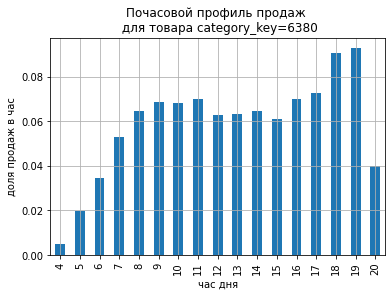

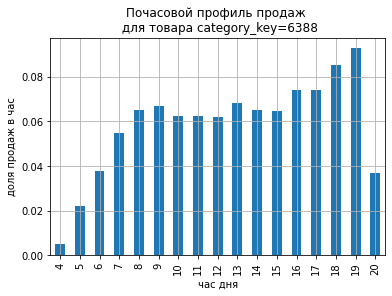

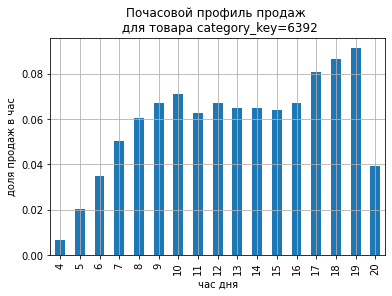

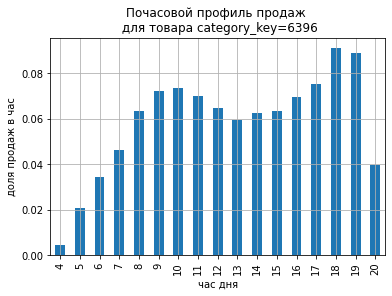

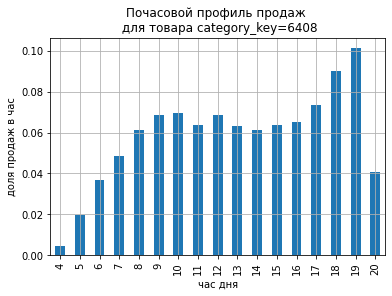

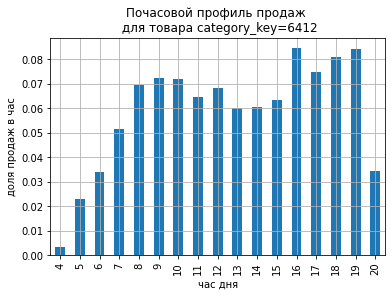

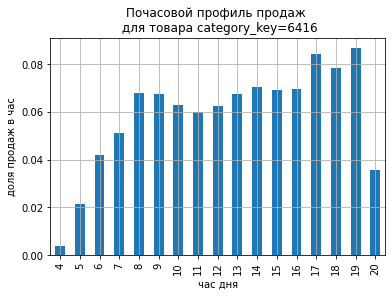

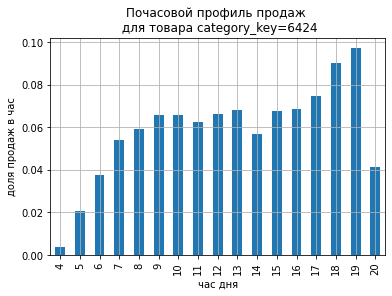

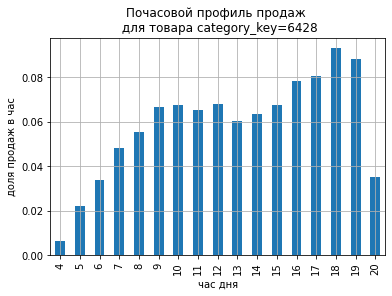

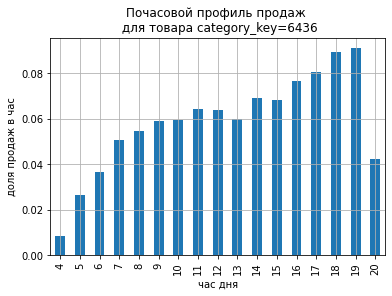

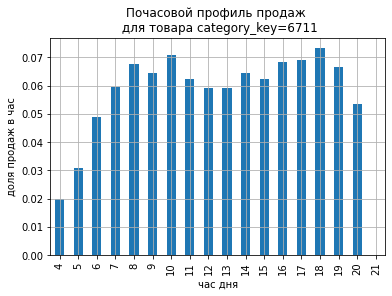

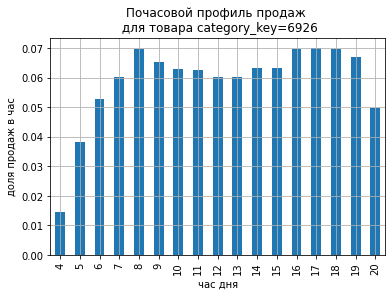

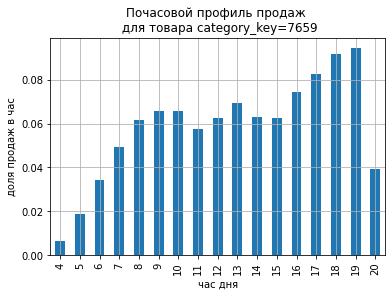

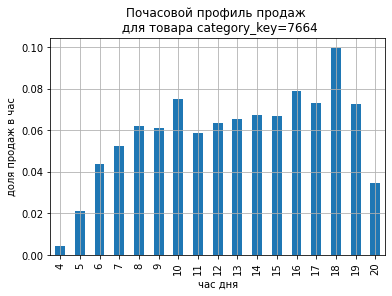

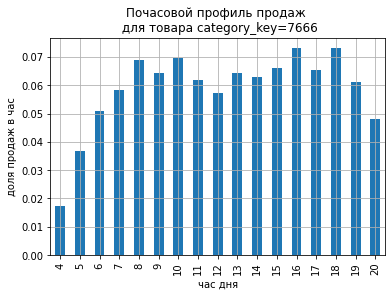

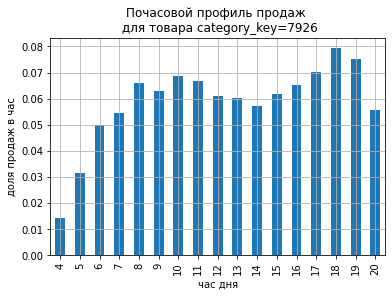

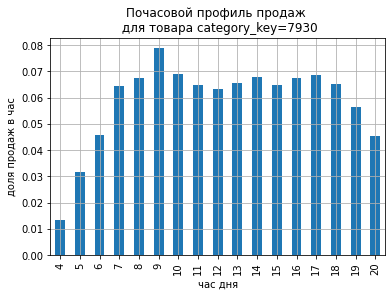

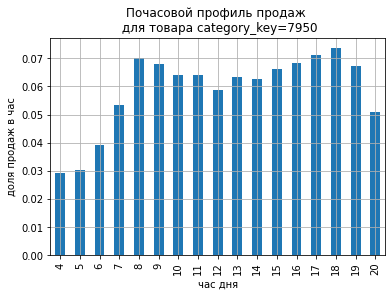

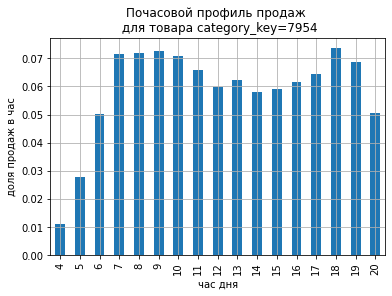

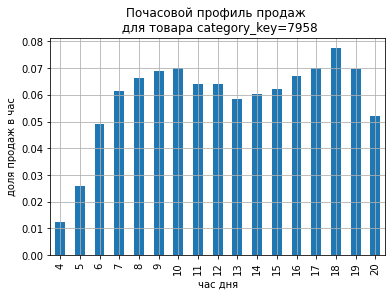

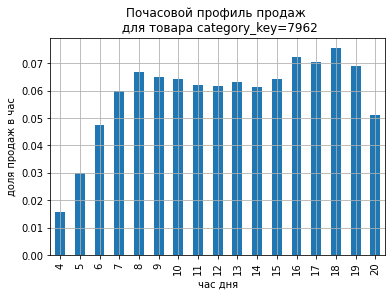

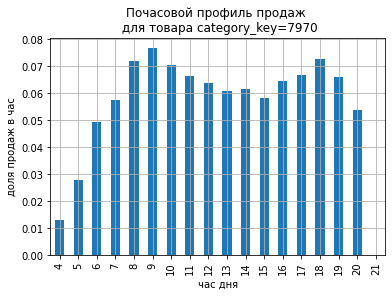

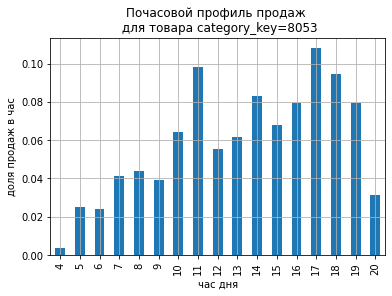

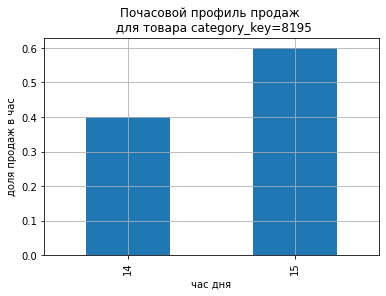

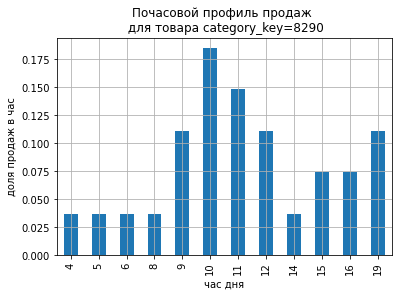

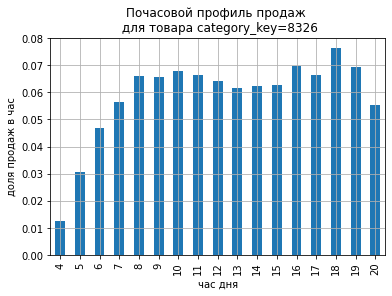

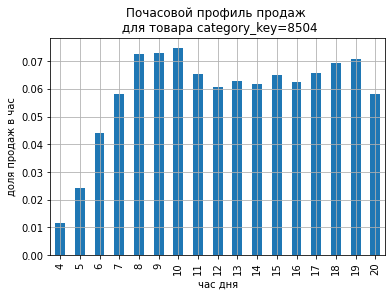

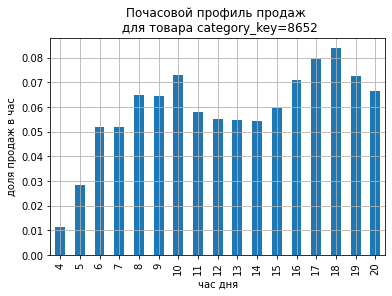

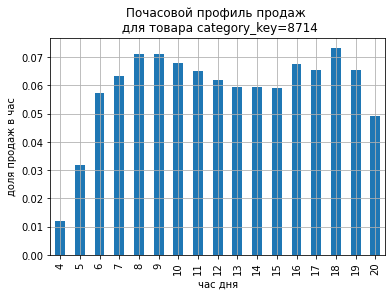

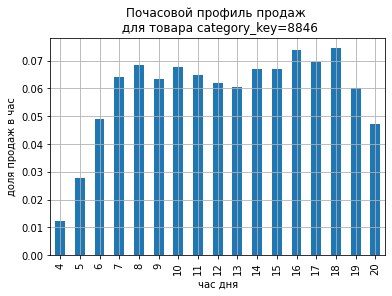

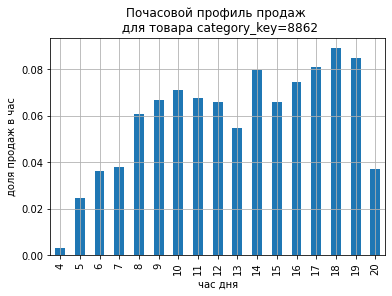

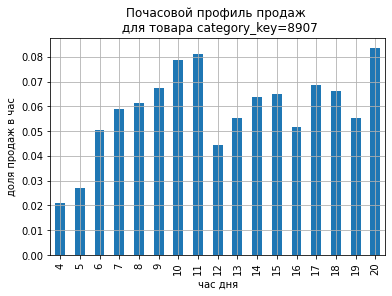

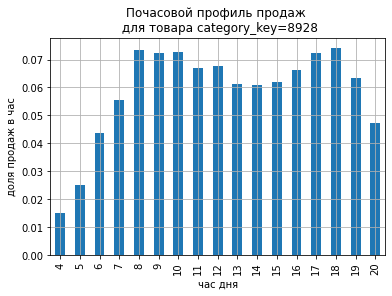

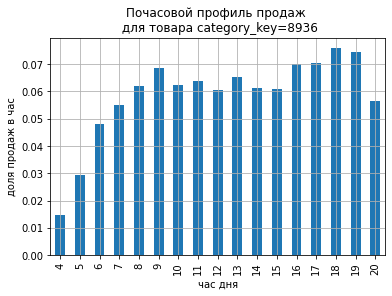

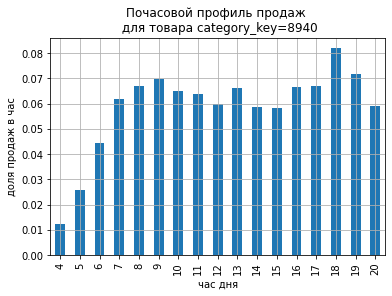

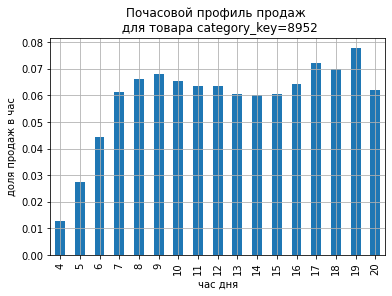

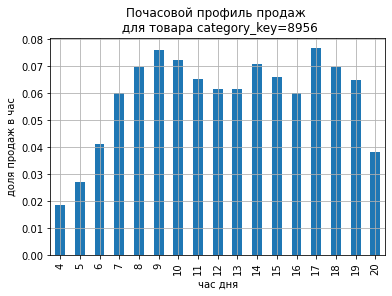

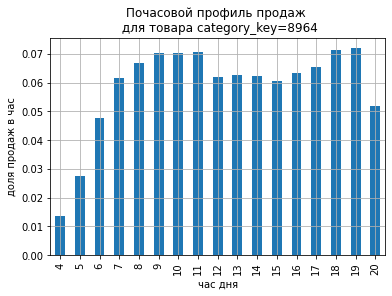

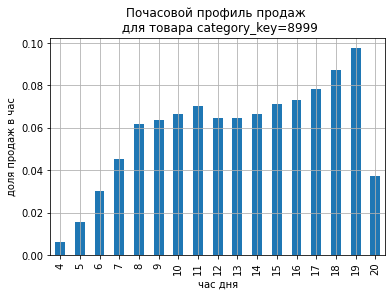

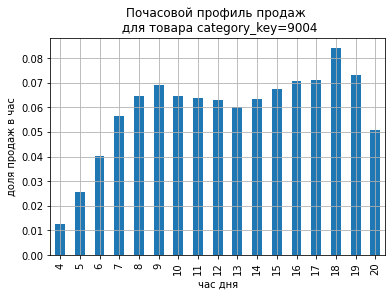

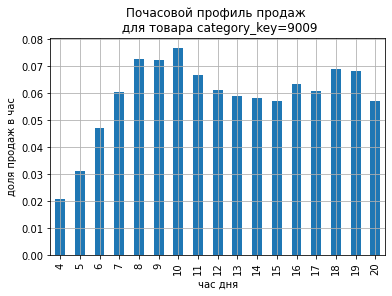

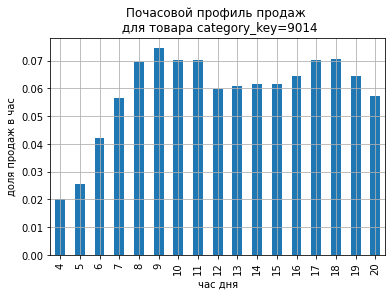

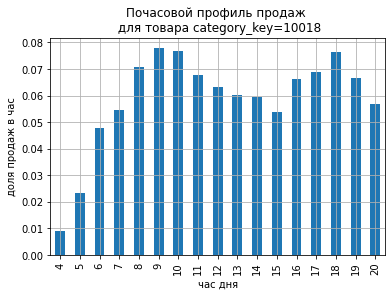

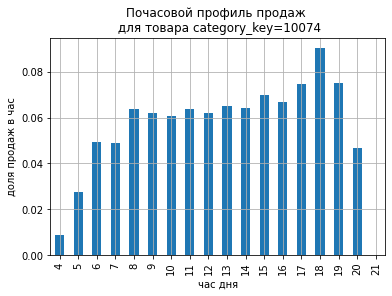

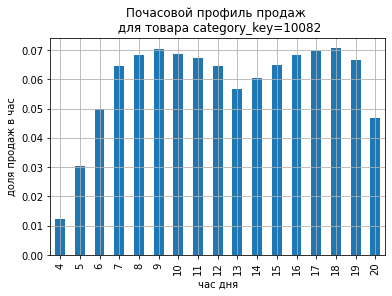

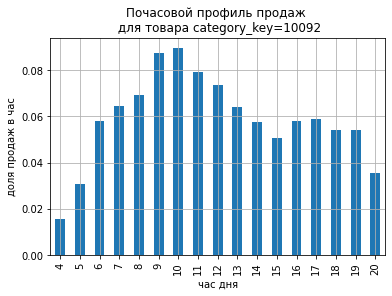

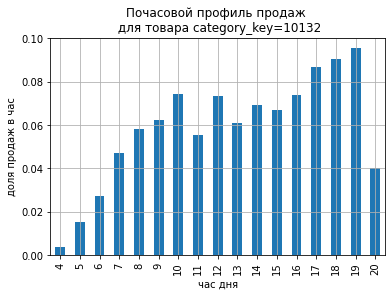

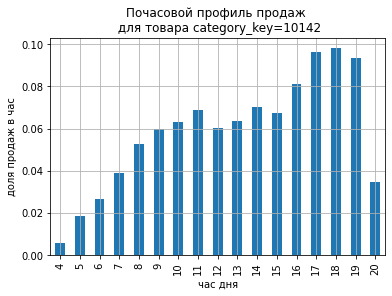

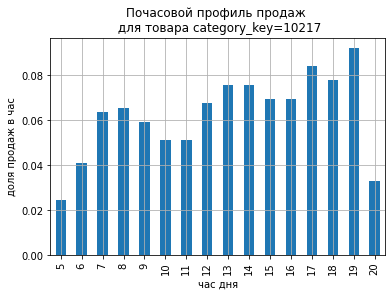

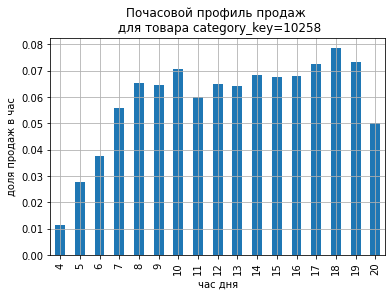

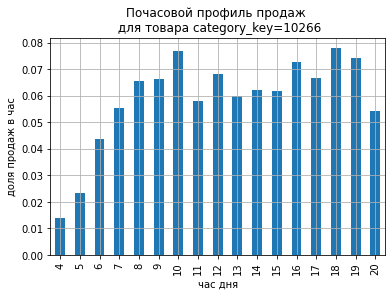

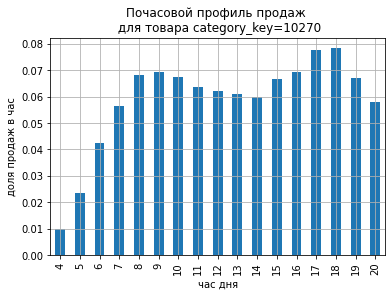

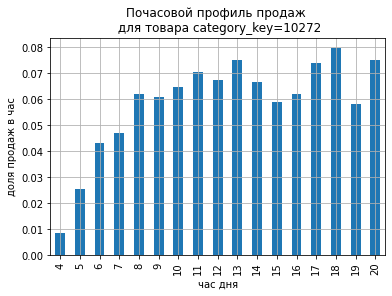

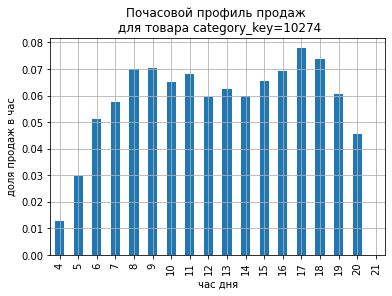

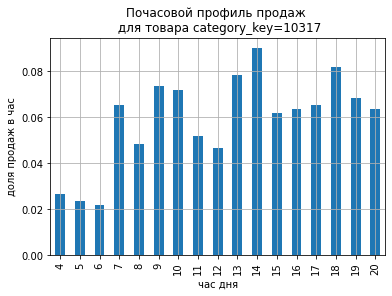

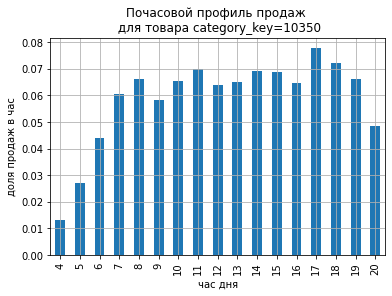

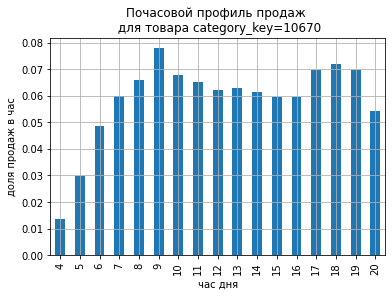

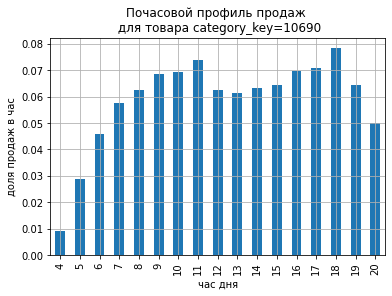

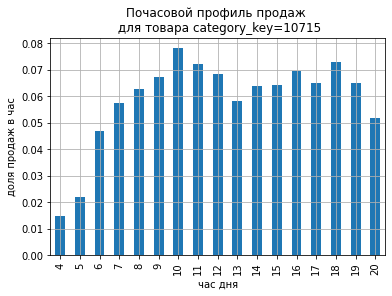

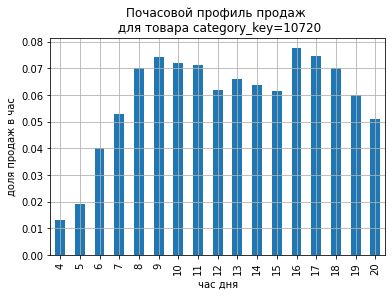

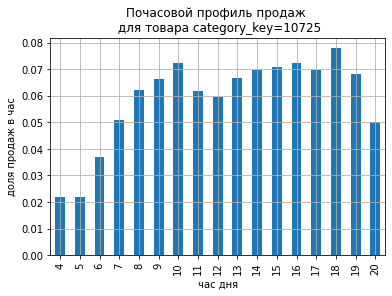

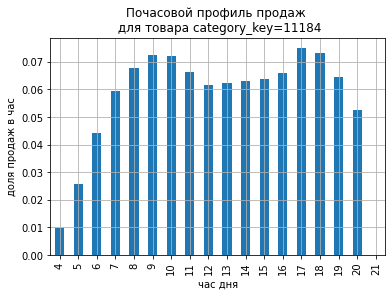

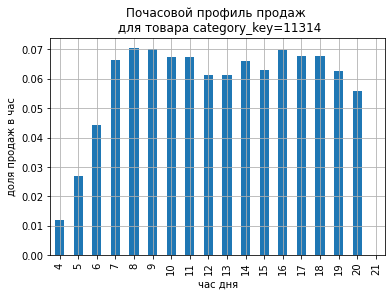

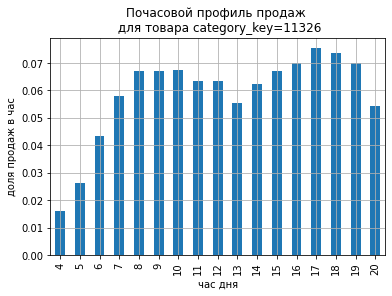

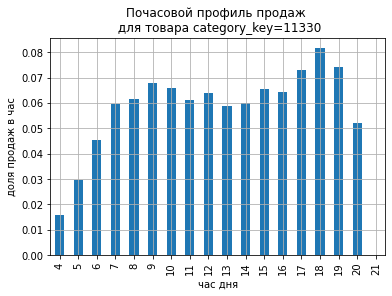

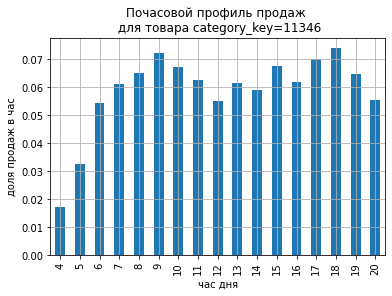

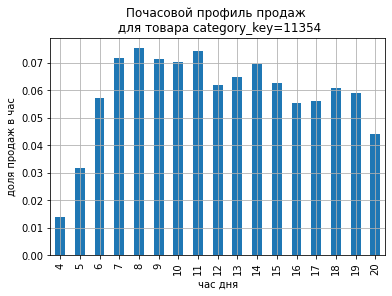

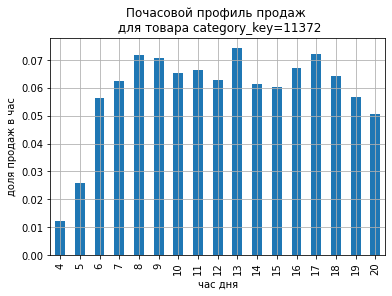

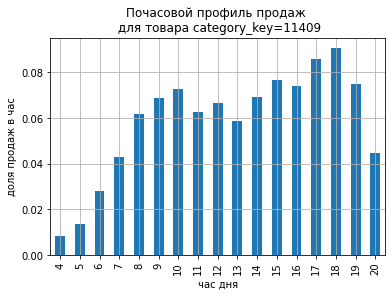

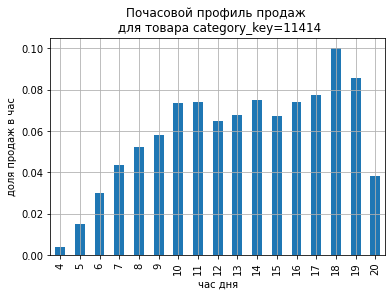

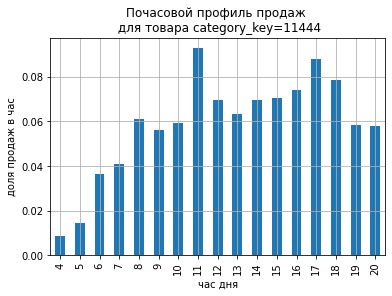

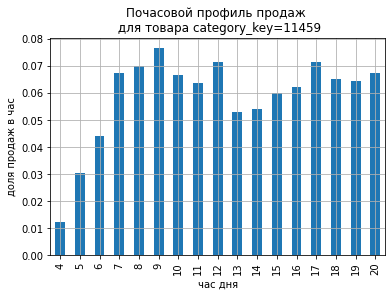

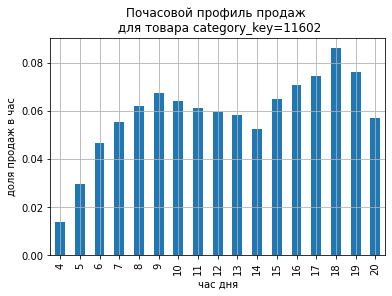

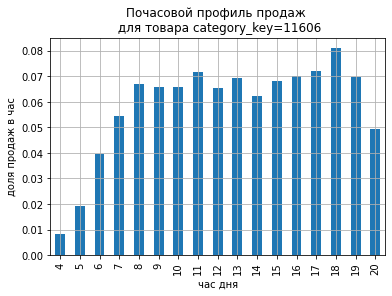

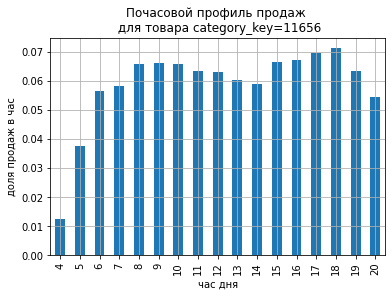

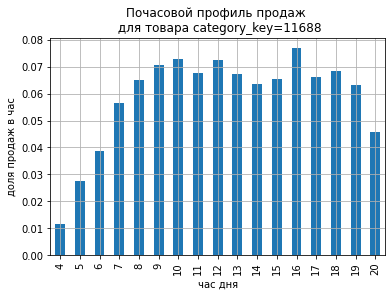

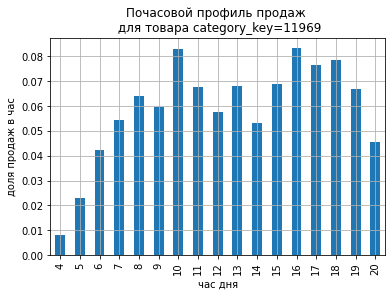

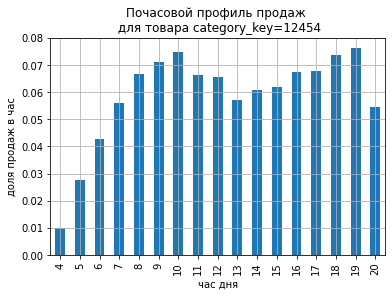

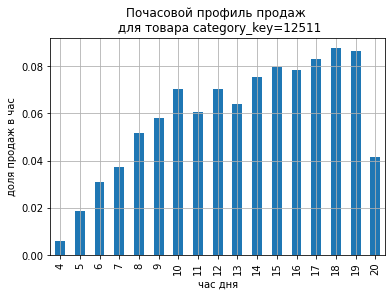

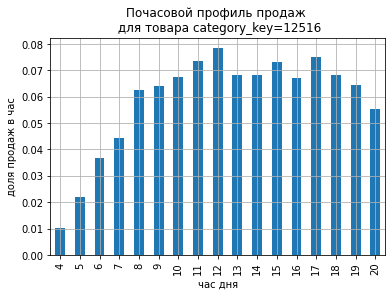

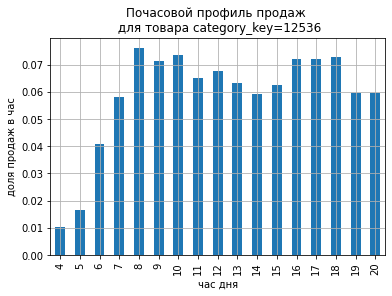

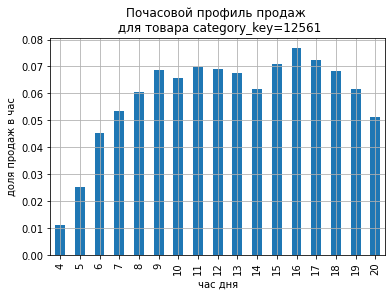

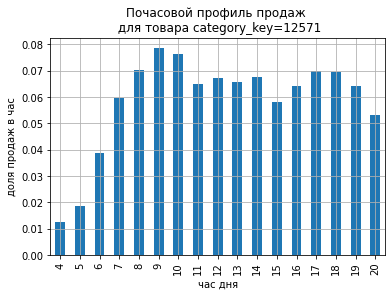

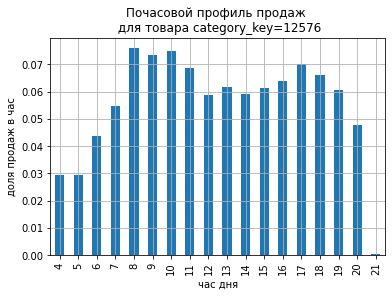

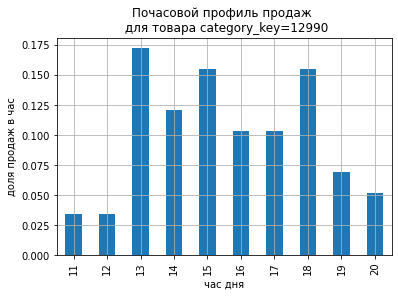

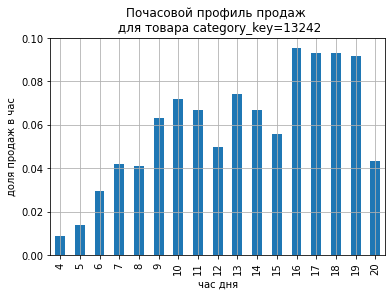

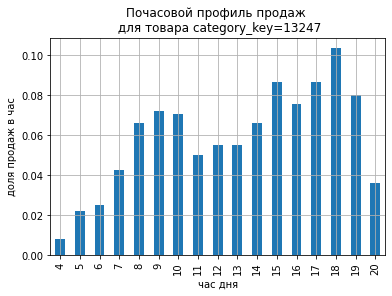

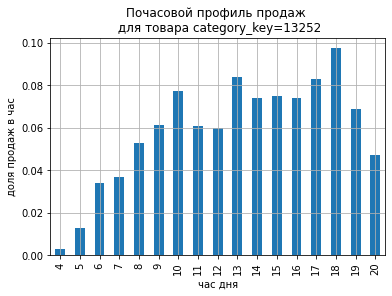

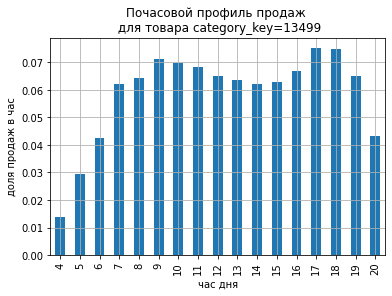

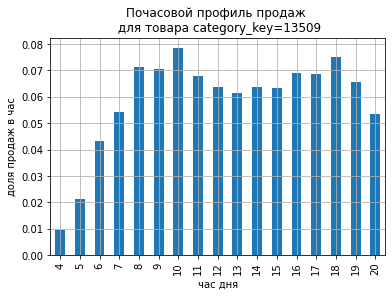

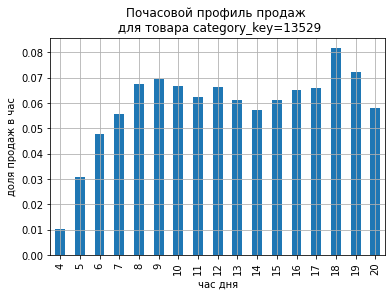

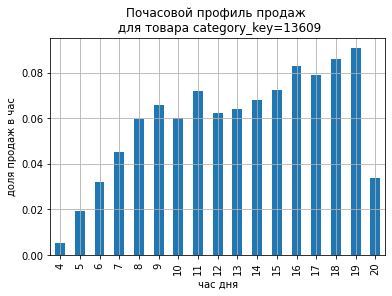

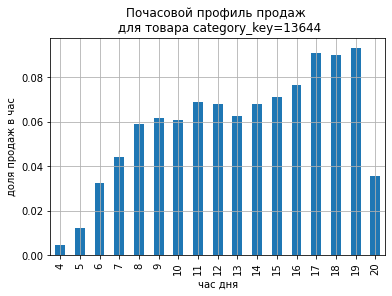

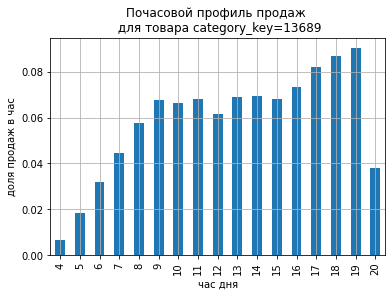

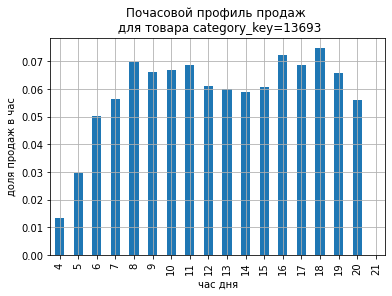

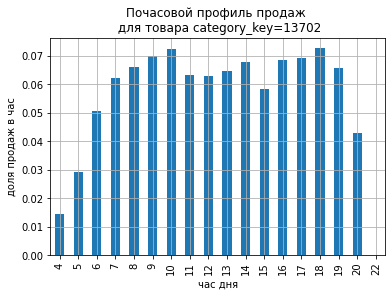

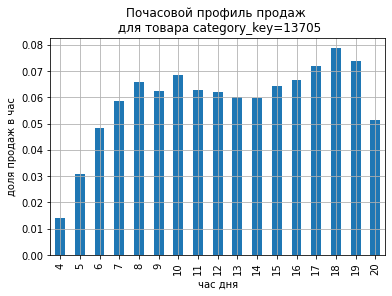

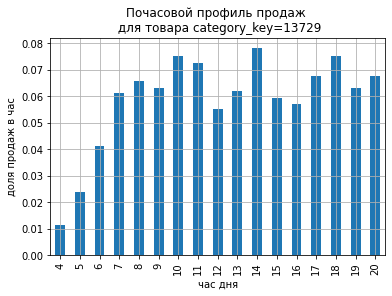

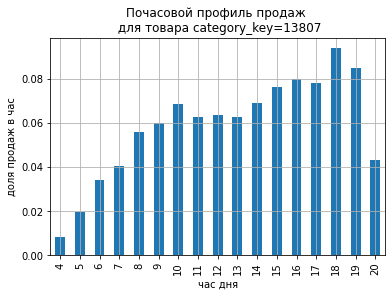

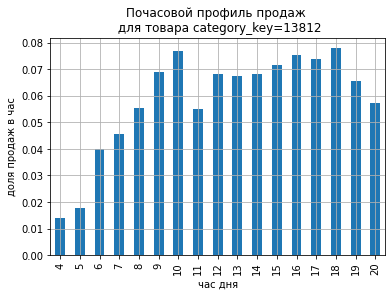

In [ ]:
def plot_hourly_profile(hourly_profile):
    hourly_profile.plot.bar()
    plt.title(f"Почасовой профиль продаж \n для товара category_key={category_key}")
    plt.xlabel('час дня')
    plt.ylabel("доля продаж в час")
    plt.grid()
    plt.show()

for category_key, category_group in df.groupby('category_id'):
    category_hourly_profile = category_group.groupby('hour')['num_sells_in_hour'].sum()
    category_hourly_profile = category_hourly_profile / category_hourly_profile.sum() # normalize profile
    plot_hourly_profile(category_hourly_profile)


Из графиков видим, что товары с достаточно длинной историей имеют гладкие почасовые профили продаж внутри дня, и часто имеют два пика продаж - утром и вечером. 

Причем некоторые товары имеют более выраженный пик в вечерние часы, что говорит о том, что какие-то товары покупатели активнее приобретают вечером.

Эти почасовые профили можно учитывать на местах в магазине, чтобы понимать, на какие товары повышенный спрос вечером, и для этих товаров вечером активнее контролировать заполняемость полок

## 2. Обучение алгоритмов прогнозирования

In [ ]:
len(full_history_categories)

135

In [ ]:
df_cleaned = df[df['category_id'].apply(lambda x: x in full_history_categories)]
assert (df_cleaned.groupby('category_id')['date'].nunique().sort_values() == MAX_HISTORY_LEN).all()

In [ ]:
from fbprophet import Prophet
from sklearn.linear_model import LinearRegression

Выносим общий код в виде отдельных функций

In [ ]:
sorted_dates = sorted(df['date'].unique())

train_date_begin = sorted_dates[0]
train_date_end = sorted_dates[27]
test_date_begin = sorted_dates[28]
test_date_end = sorted_dates[34]

print("train_date_begin:", train_date_begin)
print("train_date_end", train_date_end)

print("test_date_begin:", test_date_begin)
print("test_date_end", test_date_end)

train_date_begin: 2018-05-03
train_date_end 2018-05-30
test_date_begin: 2018-05-31
test_date_end 2018-06-06


In [ ]:
DEFAULT_FORECAST_HORIZON = 7

def train_test_split(history, 
                     train_date_begin, train_date_end,
                     test_date_begin, test_date_end):
    train = history.loc[train_date_begin:train_date_end]
    test = history.loc[test_date_begin:test_date_end]
    return train, test

def MAPE(y_true, y_predicted):
    return ((np.abs(y_true - y_predicted)) / y_true).mean()

def calculate_metrics(test, forecast, forecast_horizon=None):
    return MAPE(test, forecast)

### 2.1 Prophet

https://facebook.github.io/prophet/docs/quick_start.html



In [ ]:
def fit_predict_prophet(train, forecast_horizon=None, plot=False):
    train = train.reset_index().rename(columns={'date': 'ds', 'num_sells_in_hour': 'y'})
    model = Prophet()
    model.fit(train)
    future = model.make_future_dataframe(periods=forecast_horizon)
    forecast = model.predict(future)
    if plot:
        fig1 = model.plot(forecast)
        fig2 = model.plot_components(forecast)
    return forecast


Построим графики Prophet для одного из товаров

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


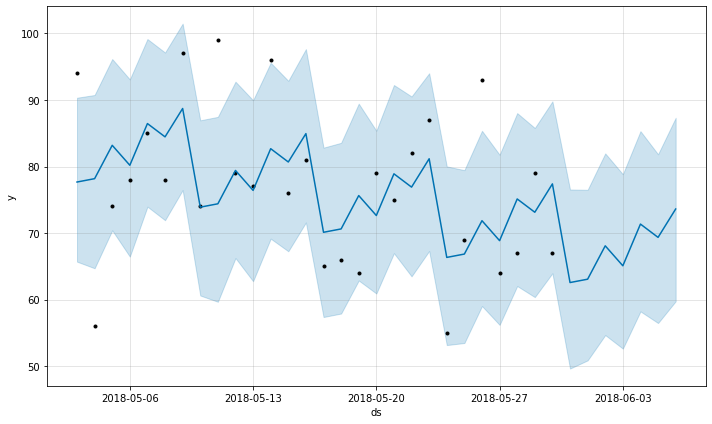

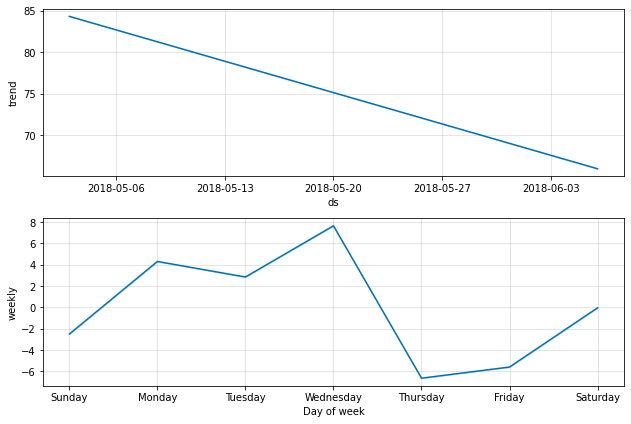

In [ ]:
for category_key, category_group in tqdm_notebook(df_cleaned.groupby('category_id')):
    category_sells_history = category_group.groupby('date')['num_sells_in_hour'].sum()
    train, test = train_test_split(category_sells_history, 
                                   train_date_begin, train_date_end,
                                   test_date_begin, test_date_end)
    forecast = fit_predict_prophet(train, forecast_horizon=DEFAULT_FORECAST_HORIZON, plot=True)
    break
    prophet_metrics_dict[category_key] = calculate_metrics(test.values, forecast.tail(DEFAULT_FORECAST_HORIZON)['yhat'].values)

Видим, что по мнению Prophet для этого товара наблюдается негативный тренд

Обучим модель отдельно для каждого товара, вычислим прогноз и посчитаем метрики

In [ ]:
prophet_metrics_dict = dict()

for category_key, category_group in tqdm_notebook(df_cleaned.groupby('category_id')):
    category_sells_history = category_group.groupby('date')['num_sells_in_hour'].sum()
    train, test = train_test_split(category_sells_history, 
                                   train_date_begin,
                                   train_date_end, test_date_begin,
                                   test_date_end)
    forecast = fit_predict_prophet(train, forecast_horizon=DEFAULT_FORECAST_HORIZON)
    prophet_metrics_dict[category_key] = calculate_metrics(
        test.values,
        forecast.tail(DEFAULT_FORECAST_HORIZON)['yhat'].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run

In [ ]:
print("Average Prophet MAPE")
print(np.array(list(prophet_metrics_dict.values())).mean())

Average Prophet MAPE
0.10296976020633075


Средняя ошибка Prophet - 10.3%

### 2.2 Линейная регрессия

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [ ]:
def fit_predict_linear_regression(train):
    train = train.values.reshape(4, 7).sum(axis=1)
    x = np.arange(len(train))
    reg = LinearRegression().fit(x.reshape(-1, 1), train)
    forecast = reg.predict(np.array(5).reshape(-1, 1))
    return np.array(forecast), reg

def plot_fitted_regression(category_key, train, reg):
    plt.title(f"оценка тренда для товара с category_key={category_key} \n с помощью линейной регрессии")
    train = train.values.reshape(4, 7).sum(axis=1)
    x = np.arange(len(train))
    plt.scatter(x, train,  color='black')
    plt.plot(x, reg.predict(x.reshape(-1, 1)), color='blue', linewidth=3)
    plt.xticks(range(4), ['1-я неделя', '2-я неделя', '3-я неделя', '4-я неделя'])
    plt.ylabel("суммарное число продаж товара за неделю")
    plt.grid()
    plt.show()


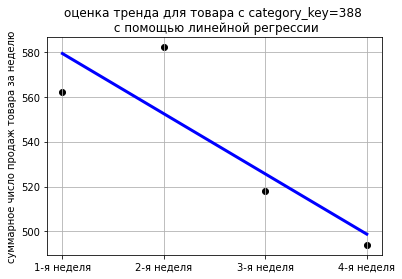

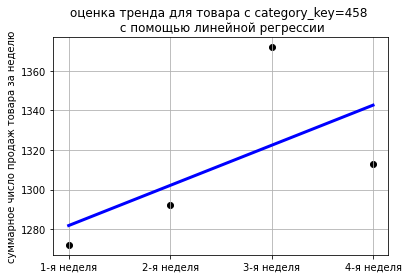

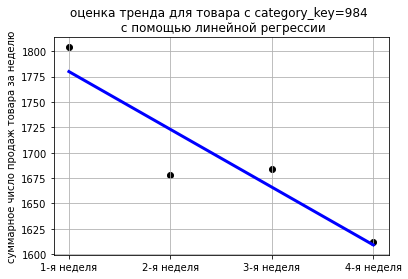

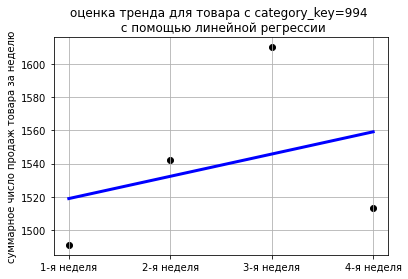

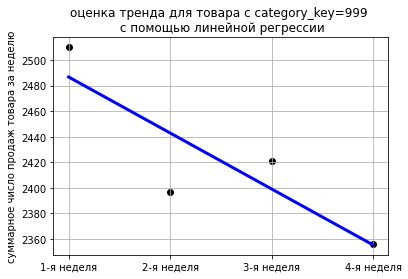

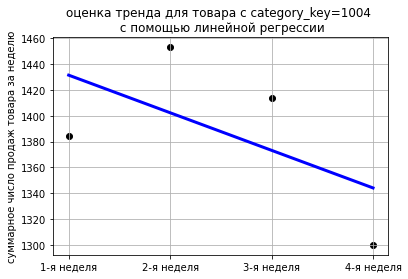

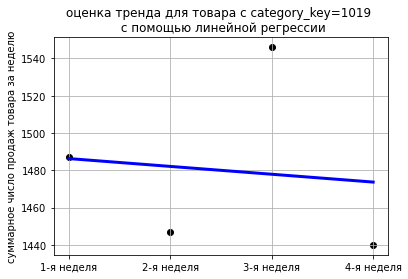

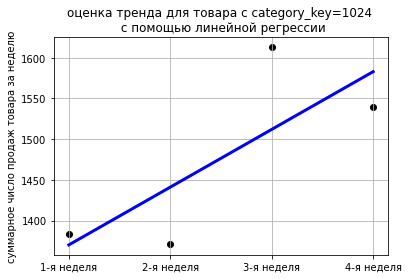

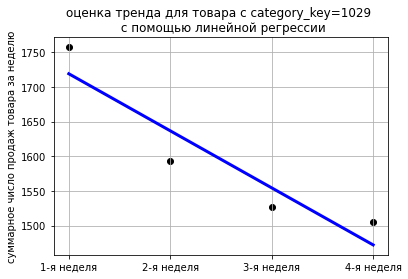

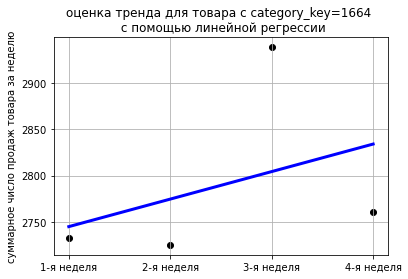

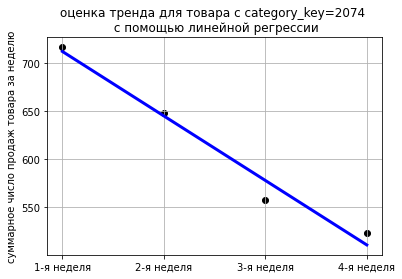

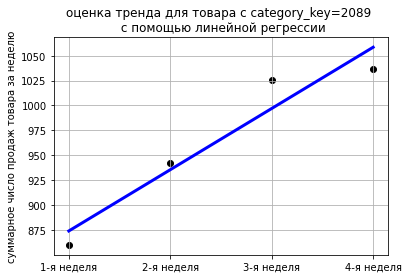

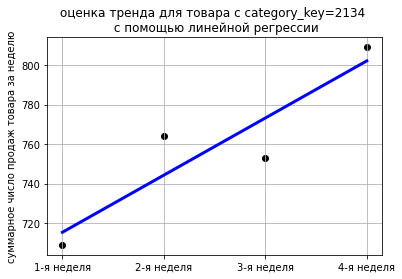

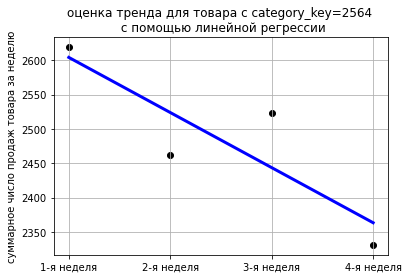

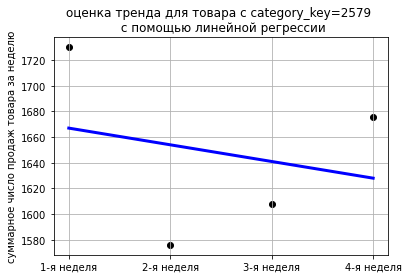

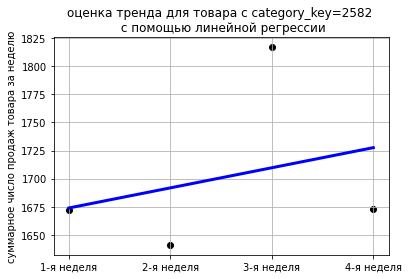

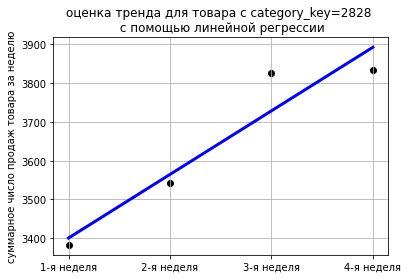

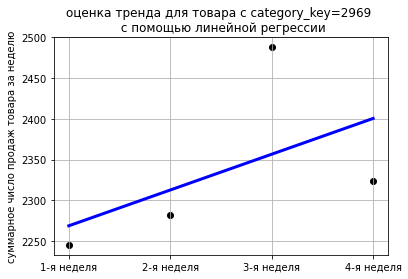

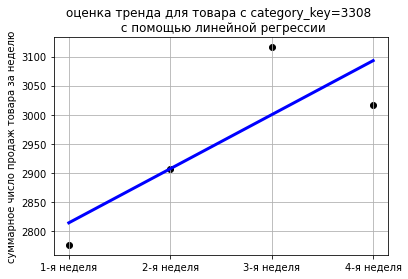

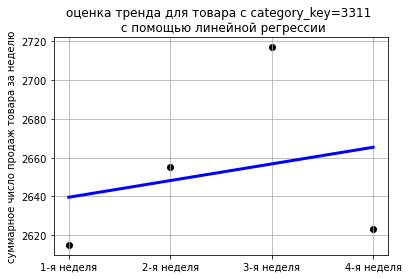

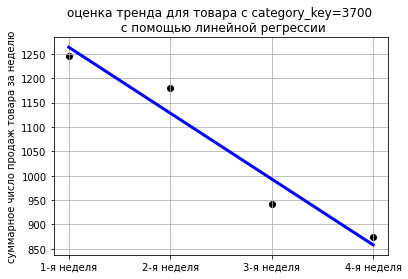

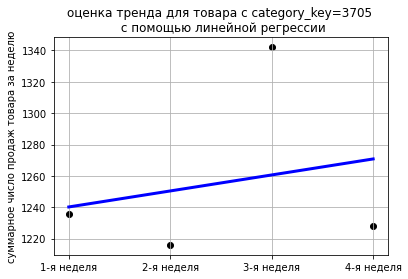

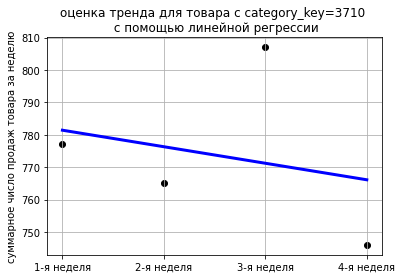

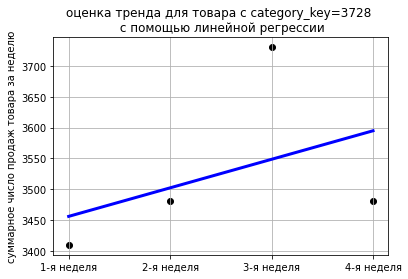

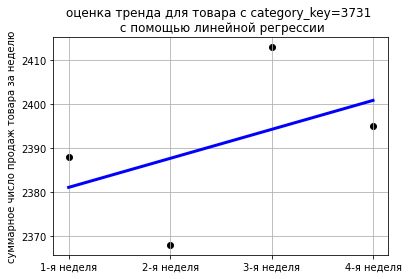

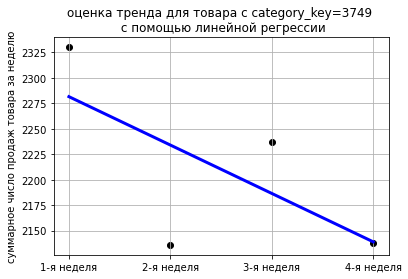

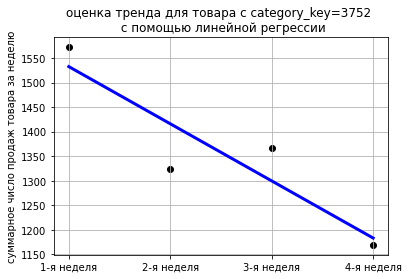

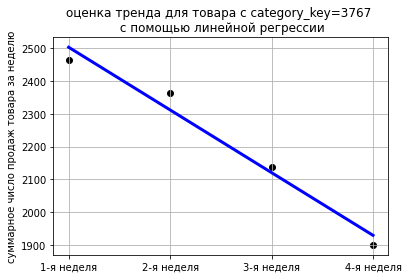

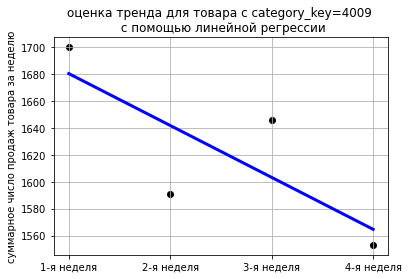

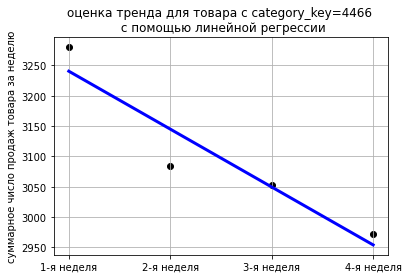

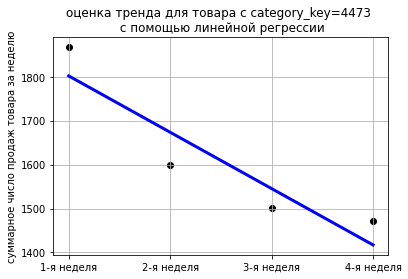

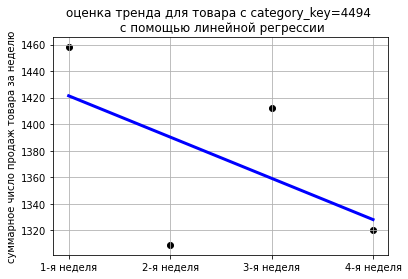

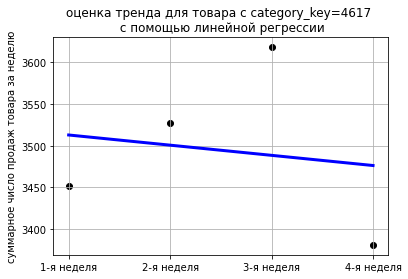

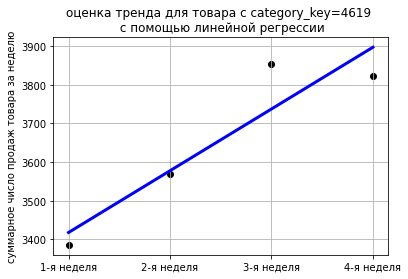

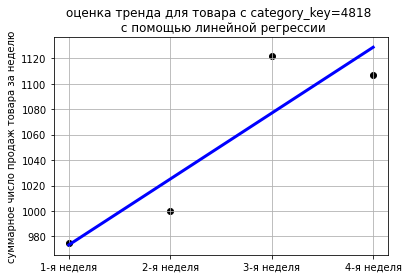

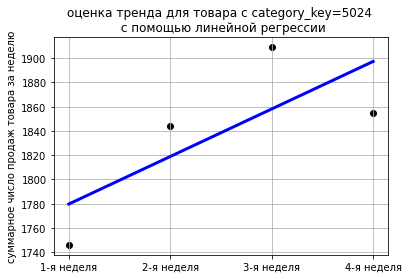

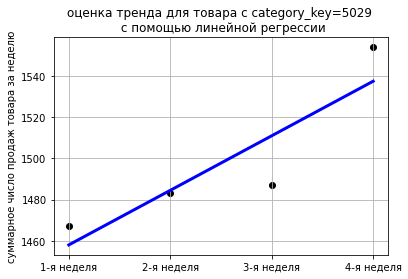

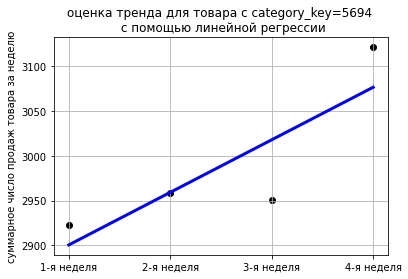

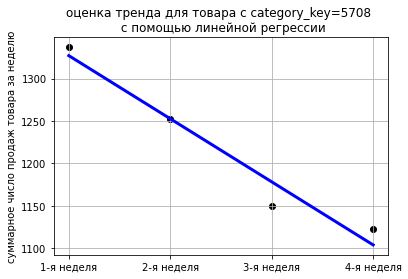

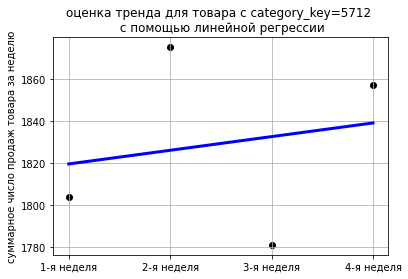

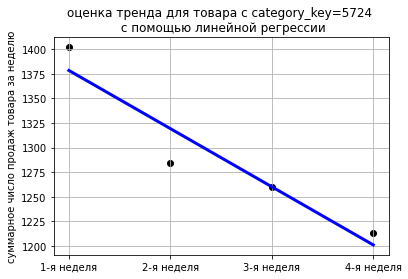

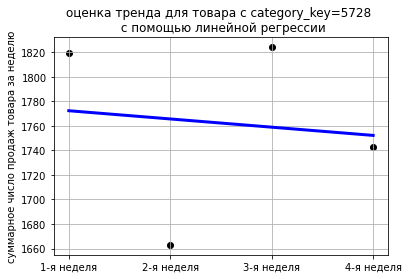

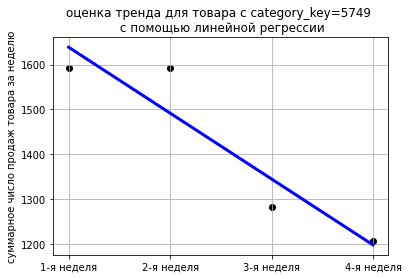

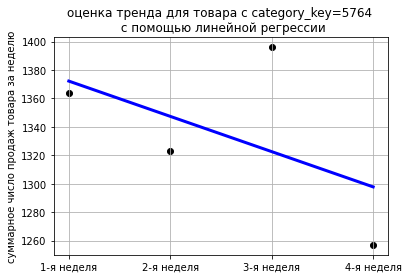

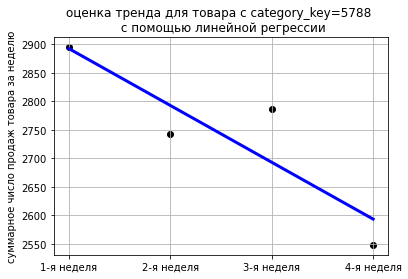

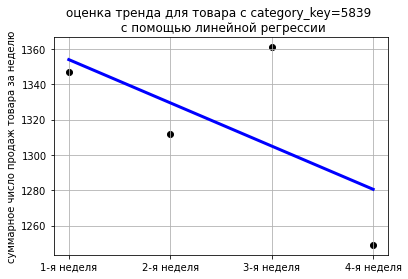

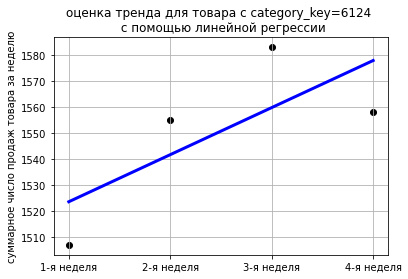

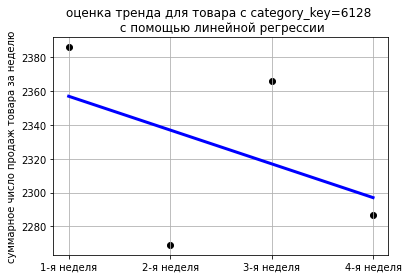

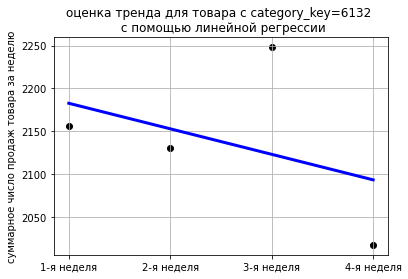

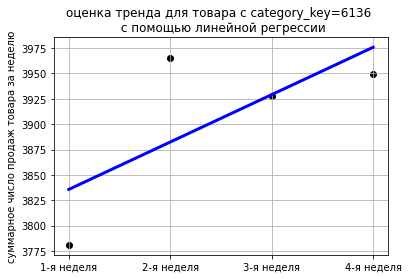

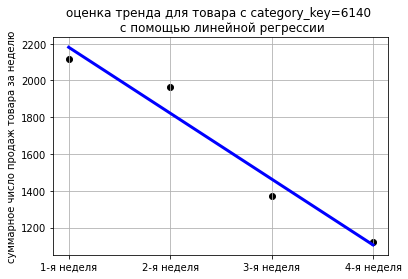

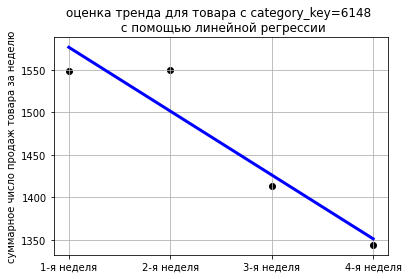

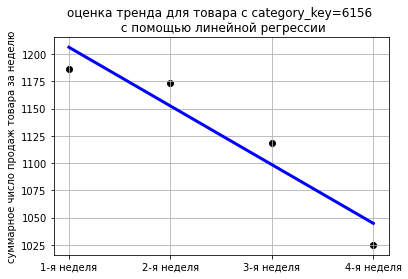

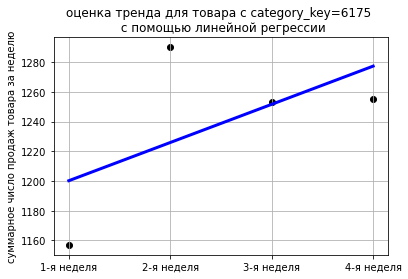

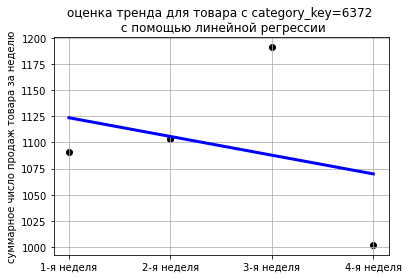

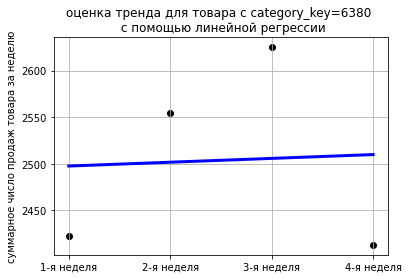

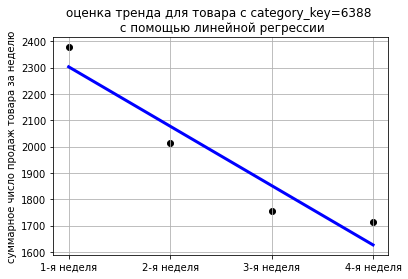

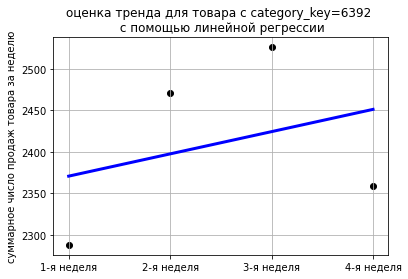

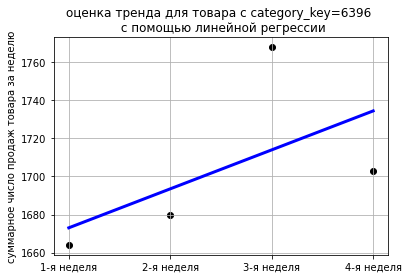

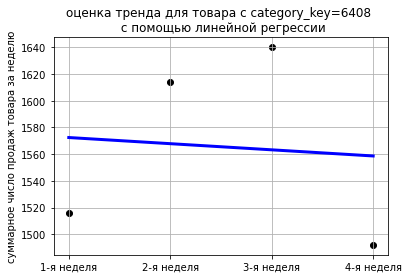

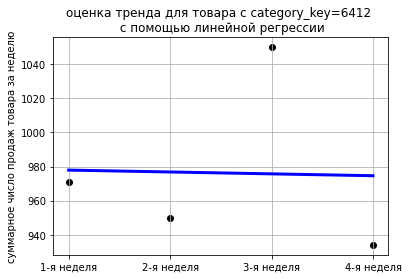

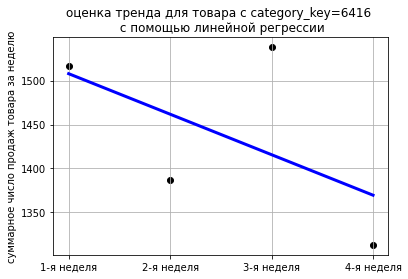

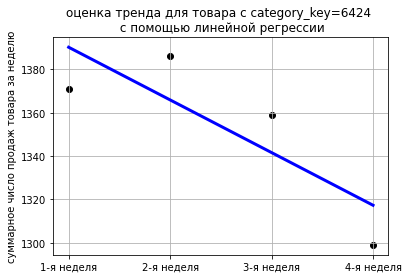

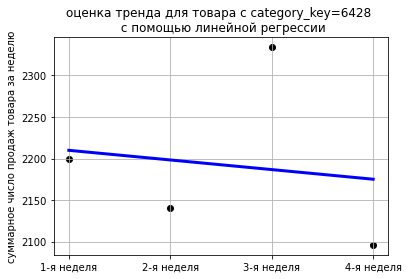

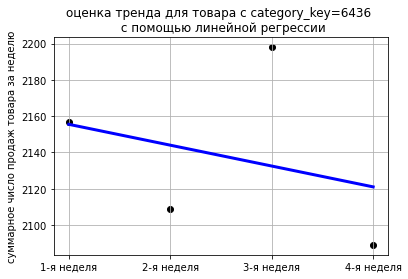

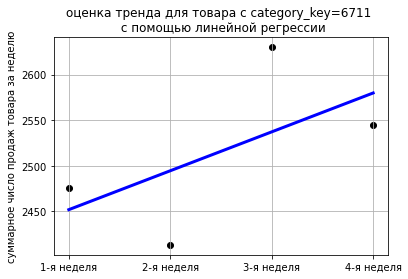

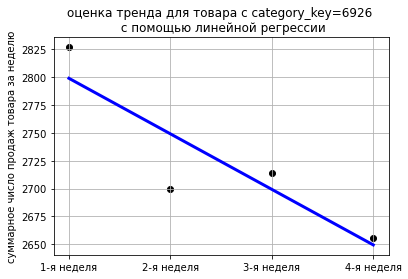

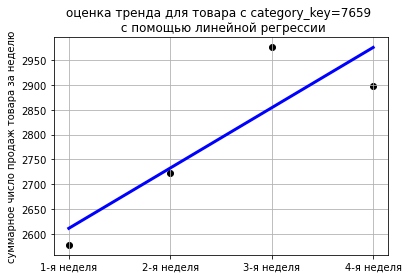

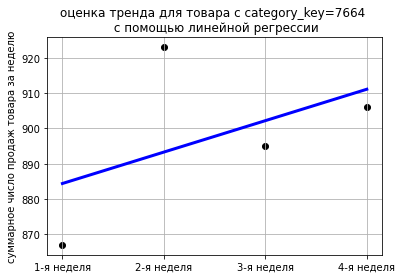

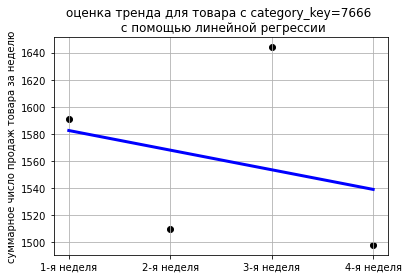

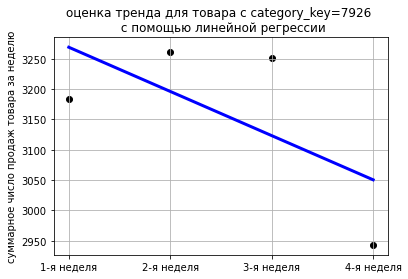

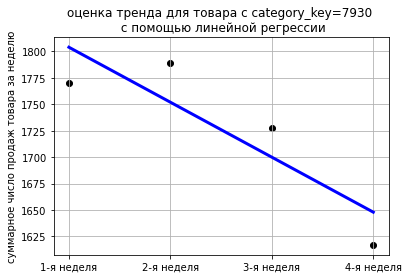

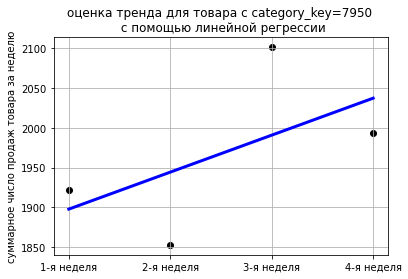

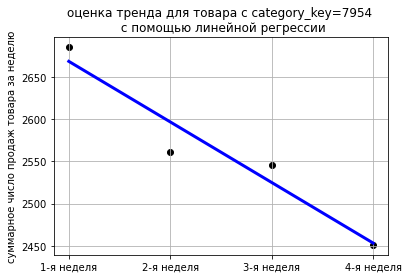

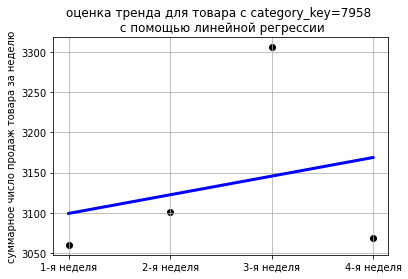

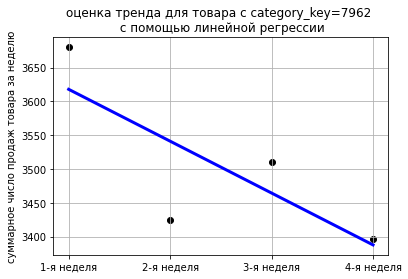

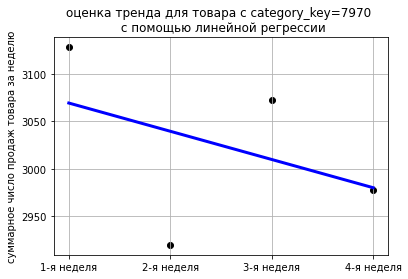

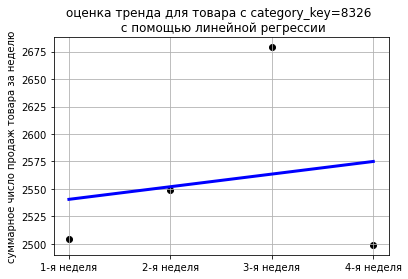

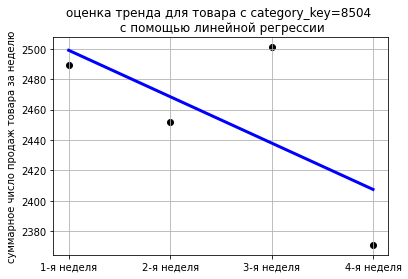

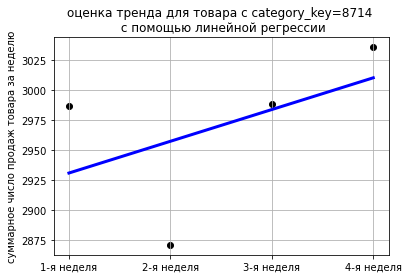

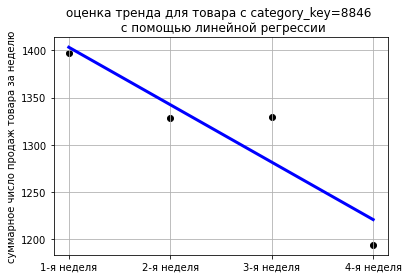

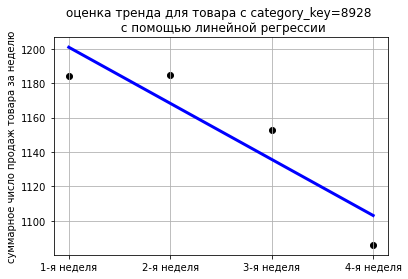

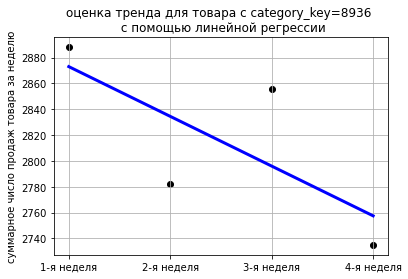

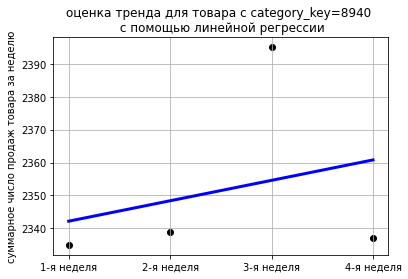

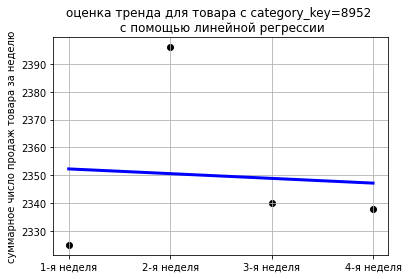

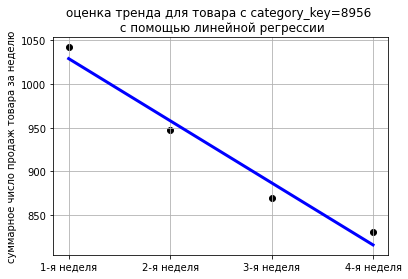

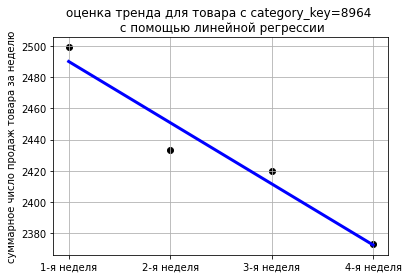

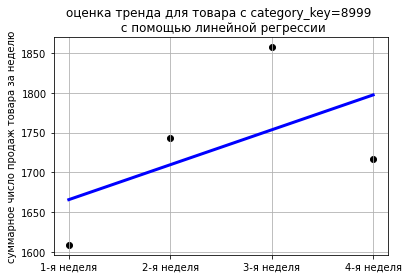

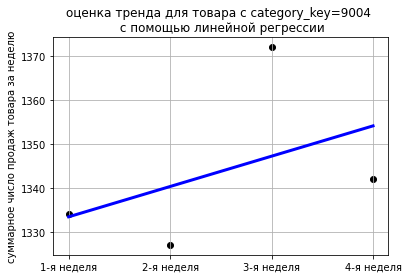

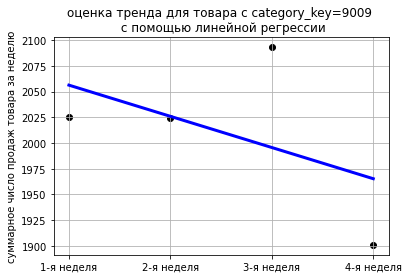

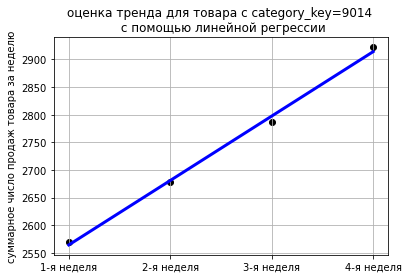

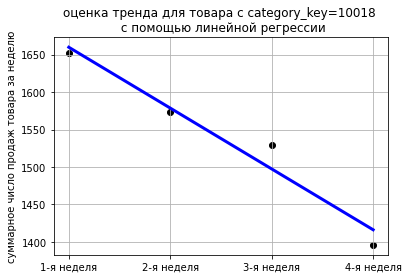

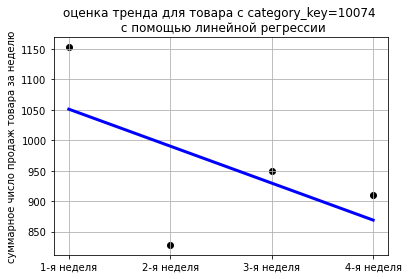

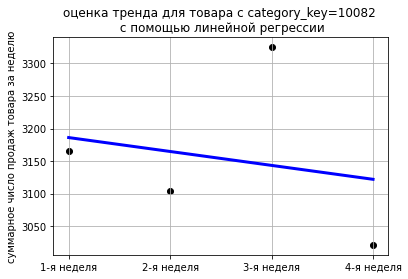

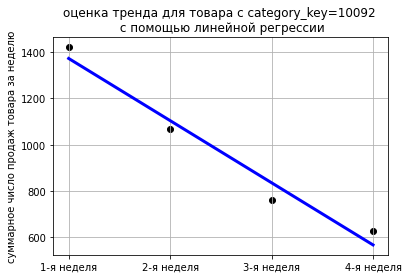

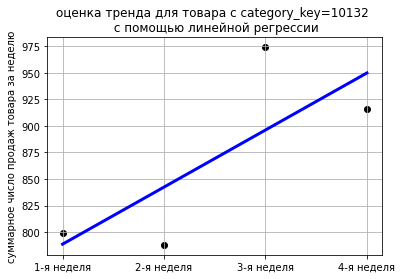

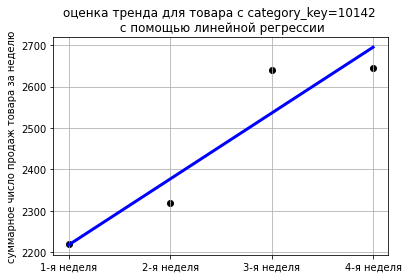

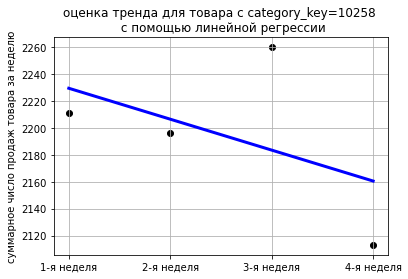

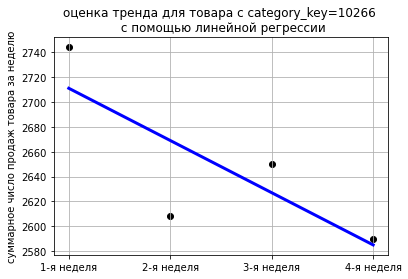

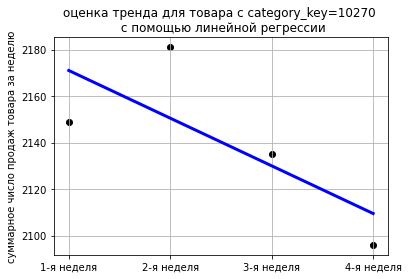

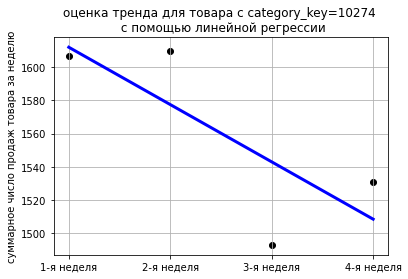

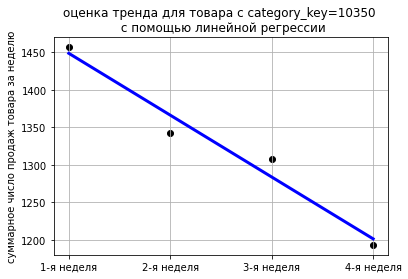

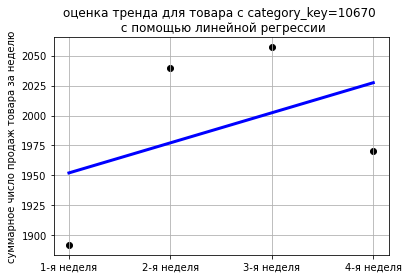

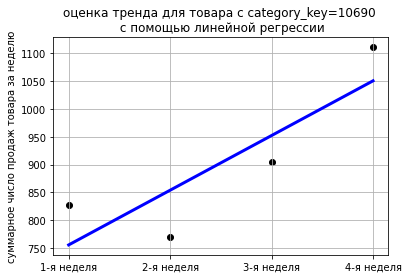

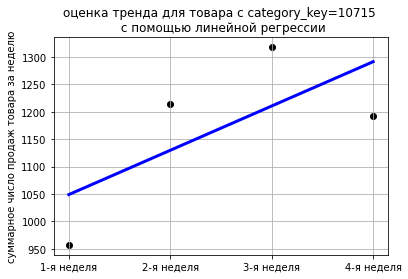

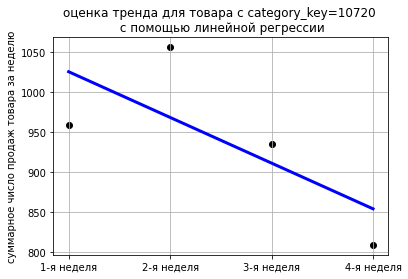

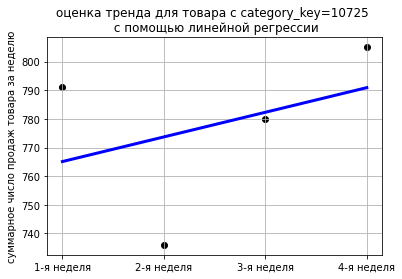

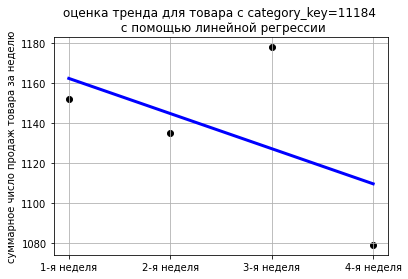

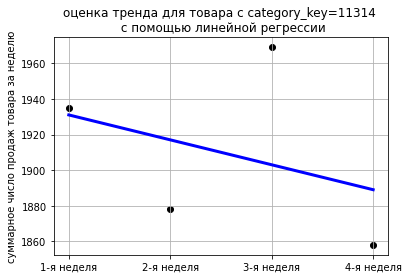

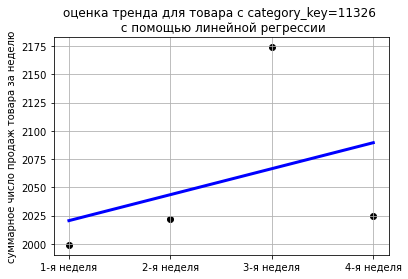

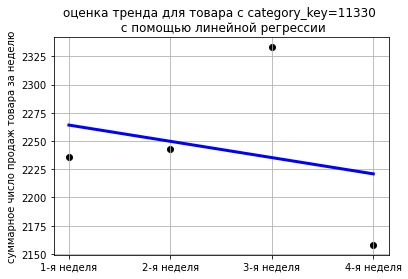

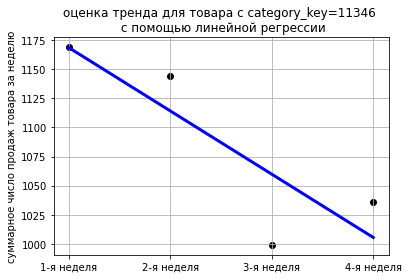

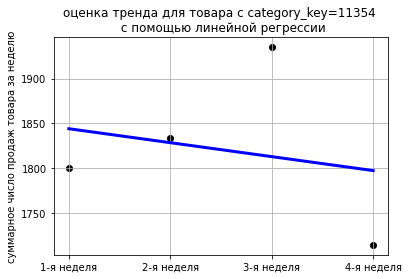

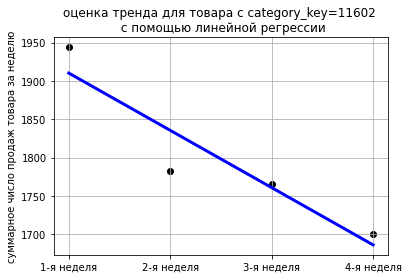

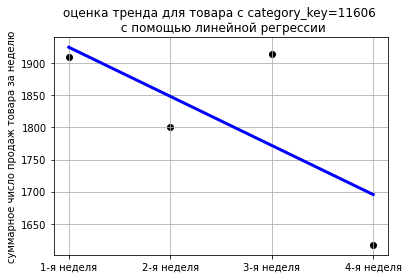

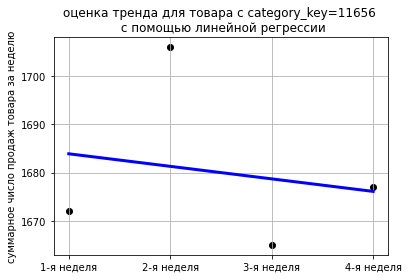

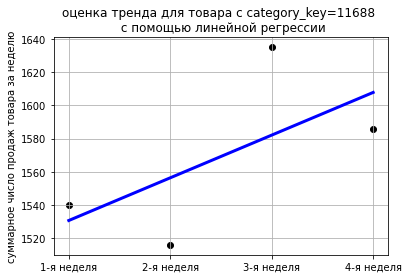

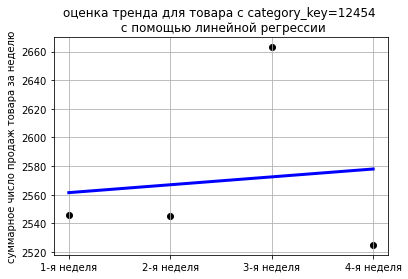

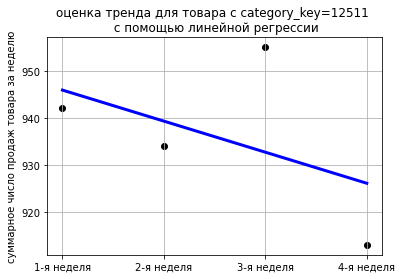

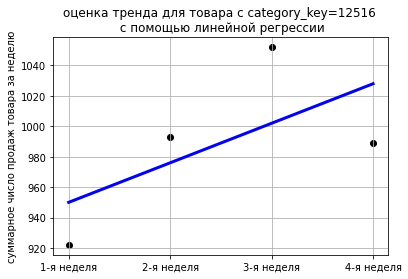

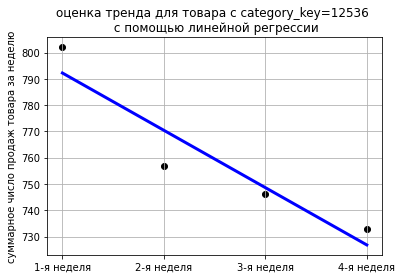

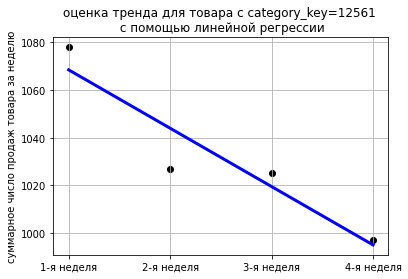

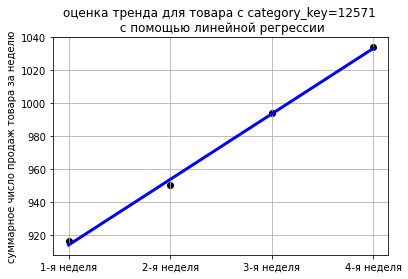

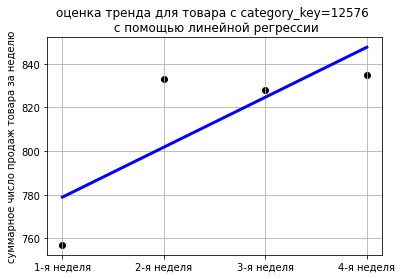

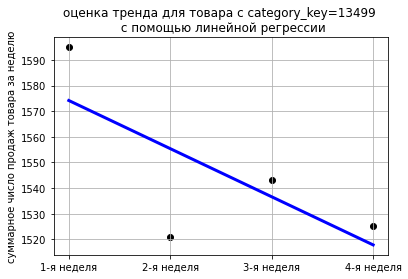

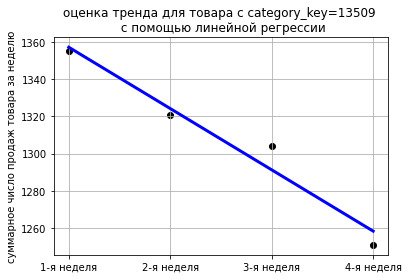

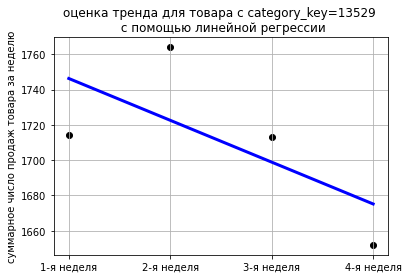

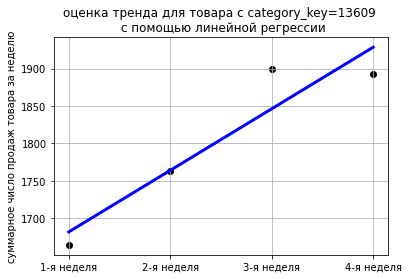

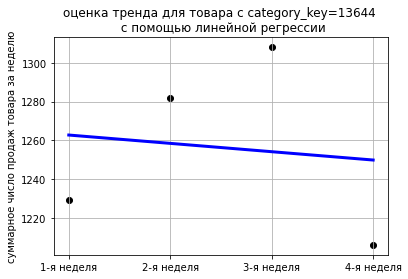

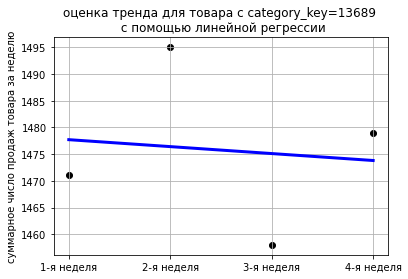

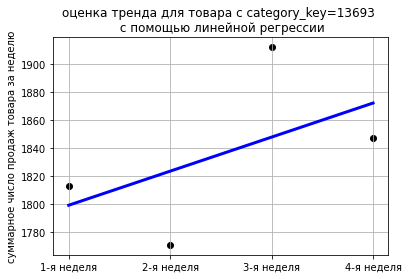

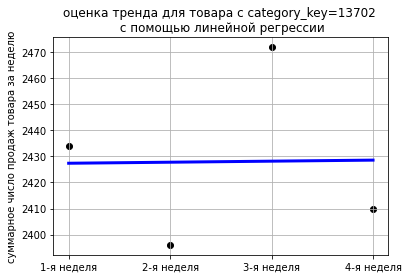

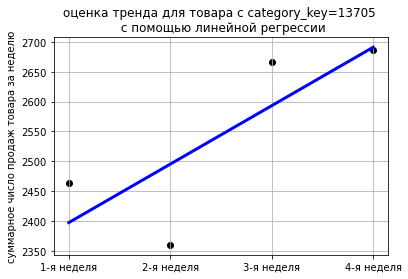

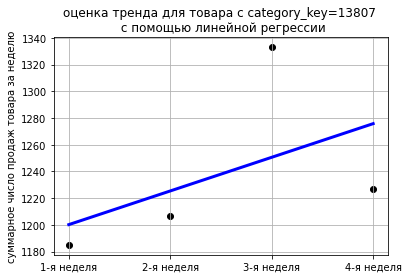

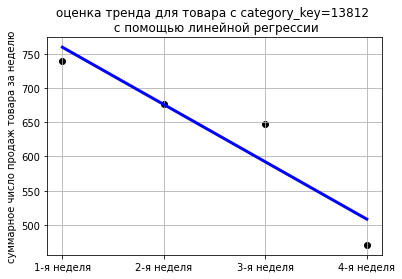

In [ ]:
linear_regression_metrics_dict = dict()

for category_key, category_group in df_cleaned.groupby('category_id'):
    category_sells_history = category_group.groupby('date')['num_sells_in_hour'].sum()
    train, test = train_test_split(category_sells_history, 
                                   train_date_begin, train_date_end,
                                   test_date_begin, test_date_end)
    forecast, model = fit_predict_linear_regression(train)
    plot_fitted_regression(category_key, train, model)
    linear_regression_metrics_dict[category_key] = calculate_metrics(test.sum(), forecast)

In [ ]:
print("Average Linear Regression MAPE")
print(np.array(list(linear_regression_metrics_dict.values())).mean())

Average Linear Regression MAPE
0.09672285055611077


## Вывод: видим, что линейная регрессия даже опережает Prophet по качеству прогнозирования.

Но если мы захотим прогнозировать не суммарное число проданных товаров за неделю по каждой категории, а число продаж товаров в каждый день, то нам придется потратить больше усилий для постпроцессинга прогноза линейной регрессии, так как нужно будет, например, вычислять подневные нормированные профили.

В защиту Prophet стоит сказать, что тратится минимально усилий на обучение модели и на подготовку данных в нужном формате, что сильно ускоряет разработку. Также стоит сказать, что Prophet может работать с любой длиной истории (хоть 2 дня, хоть 2 недели, хоть год), а для линейной регрессии для каждой длины периода пришлось бы готовить данные в своем формате, что занимает больше времени.

Для быстрой оценки качества моделей прогнозирования временных рядов можно пользоваться Prophet, так как он хорошо работает "из коробки", то есть как есть, без дополнительной настройки.